# Imports

In [14]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.

import torch
from torch_geometric.data import Data

import numpy as np
import sparse

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as tgmnn
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataListLoader as GraphLoader
from torch_geometric.data import Batch

from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
import time as time
from sklearn import preprocessing
import math
from torch.utils.data import Dataset
import copy
import sklearn.metrics as skm
import pandas as pd
import random
from torch.utils.data.dataset import Dataset
import pytorch_pretrained_bert as Bert
import itertools
from einops import rearrange, repeat
import ast
from typing import Optional, Tuple, Union
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import Adj, OptTensor, PairTensor, SparseTensor
from torch_geometric.utils import softmax
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn import LayerNorm
import torch.nn.functional as F
from torch import Tensor
import pickle
from sklearn.model_selection import ShuffleSplit
import transformers
import os
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from torchmetrics.classification import BinaryAccuracy
from tqdm import tqdm
from matplotlib import pyplot as plt

from torch.utils.tensorboard import SummaryWriter

In [ ]:
# if you are using a mac this cell aims to solve this error: 
# NotImplementedError: The operator 'aten::scatter_reduce.two_out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable ⁠ PYTORCH_ENABLE_MPS_FALLBACK=1 ⁠ to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

# You will probably need first to execute this bash command in your terminal: touch .zshenv && echo 'export PYTORCH_ENABLE_MPS_FALLBACK=1' >> .zshenv
# And then restart the notebook

#import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# MODELE

In [2]:


class TransformerConv(MessagePassing):
    _alpha: OptTensor
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        heads: int = 1,
        concat: bool = True,
        beta: bool = False,
        dropout: float = 0.,
        edge_dim: Optional[int] = None,
        bias: bool = True,
        root_weight: bool = True,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.beta = beta and root_weight
        self.root_weight = root_weight
        self.concat = concat
        self.dropout = dropout
        self.edge_dim = edge_dim
        self._alpha = None

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_key = Linear(in_channels[0], heads * out_channels)
        self.lin_query = Linear(in_channels[1], heads * out_channels)
        self.lin_value = Linear(in_channels[0], heads * out_channels)
        self.layernorm1 = LayerNorm(out_channels)
        self.layernorm2 = LayerNorm(out_channels)
        self.gelu = nn.GELU()
        self.proj = Linear(heads * out_channels, out_channels)
        self.ffn = Linear(out_channels, out_channels)
        self.ffn2 = Linear(out_channels, out_channels)
        if edge_dim is not None:
            self.lin_edge = Linear(edge_dim, heads * out_channels, bias=False)
        else:
            self.lin_edge = self.register_parameter('lin_edge', None)


        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        self.lin_key.reset_parameters()
        self.lin_query.reset_parameters()
        self.lin_value.reset_parameters()
        if self.edge_dim:
            self.lin_edge.reset_parameters()


    def forward(self, x: Union[Tensor, PairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, batch=None, return_attention_weights=None):
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, bool) -> Tuple[Tensor, SparseTensor]  # noqa
        r"""Runs the forward pass of the module.

        Args:
            return_attention_weights (bool, optional): If set to :obj:`True`,
                will additionally return the tuple
                :obj:`(edge_index, attention_weights)`, holding the computed
                attention weights for each edge. (default: :obj:`None`)
        """
        H, C = self.heads, self.out_channels
        residual = x
        x = self.layernorm1(x, batch)
        if isinstance(x, Tensor):
            x: PairTensor = (x, x)
        query = self.lin_query(x[1]).view(-1, H, C)
        key = self.lin_key(x[0]).view(-1, H, C)
        value = self.lin_value(x[0]).view(-1, H, C)
        # propagate_type: (query: Tensor, key:Tensor, value: Tensor, edge_attr: OptTensor) # noqa
        out = self.propagate(edge_index, query=query, key=key, value=value,
                             edge_attr=edge_attr, size=None)
        alpha = self._alpha
        self._alpha = None
        if self.concat:
            out = self.proj(out.view(-1, self.heads * self.out_channels))
        else:
            out = out.mean(dim=1)
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = out+residual
        residual = out

        out = self.layernorm2(out)
        out = self.gelu(self.ffn(out))
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = self.ffn2(out)
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = out + residual
        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out

    def message(self, query_i: Tensor, key_j: Tensor, value_j: Tensor,
                edge_attr: OptTensor, index: Tensor, ptr: OptTensor,
                size_i: Optional[int]) -> Tensor:


        if self.lin_edge is not None:
            assert edge_attr is not None
            edge_attr = self.lin_edge(edge_attr).view(-1, self.heads,
                                                      self.out_channels)
            key_j = key_j + edge_attr

        alpha = (query_i * key_j).sum(dim=-1) / math.sqrt(self.out_channels)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        out = value_j
        if edge_attr is not None:
            out = out + edge_attr

        out = out * alpha.view(-1, self.heads, 1)
        return out

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, heads={self.heads})')


class GraphTransformer(torch.nn.Module):
    def __init__(self, config):
        super().__init__()

        self.transformerconv1 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=True)
        self.transformerconv2 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=True)
        self.transformerconv3 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=False)

        self.embed = nn.Embedding(config.vocab_size, config.hidden_size // 5)
        self.embed_ee = nn.Embedding(config.node_attr_size, config.hidden_size // 5)

    def forward(self, x, edge_index, edge_attr, batch):
        indices = (x==0).nonzero().squeeze()
        h_nodes = self.transformerconv1(x=self.embed(x), edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        h_nodes = nn.GELU()(h_nodes)
        h_nodes = self.transformerconv2(x=h_nodes, edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        h_nodes = nn.GELU()(h_nodes)
        h_nodes = self.transformerconv3(x=h_nodes, edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        x = h_nodes[indices]
        return x



class BertEmbeddings(nn.Module):
    """Construct the embeddings from word, segment, age
    """

    def __init__(self, config):
        super(BertEmbeddings, self).__init__()
        #self.word_embeddings = nn.Linear(config.vocab_size, config.hidden_size)
        self.word_embeddings = GraphTransformer(config)
        self.type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size//5)
        self.age_embeddings = nn.Embedding(config.age_vocab_size, config.hidden_size//5). \
            from_pretrained(embeddings=self._init_posi_embedding(config.age_vocab_size, config.hidden_size//5))
        self.time_embeddings = nn.Embedding(config.time_vocab_size , config.hidden_size//5). \
            from_pretrained(embeddings=self._init_posi_embedding(config.time_vocab_size, config.hidden_size//5))
        self.posi_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size//5). \
            from_pretrained(embeddings=self._init_posi_embedding(config.max_position_embeddings, config.hidden_size//5))


        self.seq_layers = nn.Sequential(
            nn.LayerNorm(config.hidden_size),
            nn.Dropout(config.hidden_dropout_prob),
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.GELU(),
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.GELU()
        )

        self.LayerNorm = nn.LayerNorm(config.hidden_size)
        self.acti = nn.GELU()
        self.cls_token = nn.Parameter(torch.randn(1, 1, config.hidden_size))

    def forward(self, nodes, edge_index,  edge_attr, batch, age_ids, time_ids,  type_ids, posi_ids):
        word_embed = self.word_embeddings(nodes, edge_index, edge_attr, batch)
        type_embeddings = self.type_embeddings(type_ids)
        age_embed = self.age_embeddings(age_ids)
        time_embeddings = self.time_embeddings(time_ids)
        posi_embeddings = self.posi_embeddings(posi_ids)

        word_embed = torch.reshape(word_embed, type_embeddings.shape)
        embeddings = torch.cat((word_embed, type_embeddings, posi_embeddings, age_embed, time_embeddings), dim=2)
        
        b, n, _ = embeddings.shape
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        embeddings = torch.cat((cls_tokens, embeddings), dim=1)
        embeddings = self.seq_layers(embeddings)
        embeddings = self.LayerNorm(embeddings)
        
        return embeddings

    def _init_posi_embedding(self, max_position_embedding, hidden_size):
        def even_code(pos, idx):
            return np.sin(pos / (10000 ** (2 * idx / hidden_size)))

        def odd_code(pos, idx):
            return np.cos(pos / (10000 ** (2 * idx / hidden_size)))

        # initialize position embedding table
        lookup_table = np.zeros((max_position_embedding, hidden_size), dtype=np.float32)

        # reset table parameters with hard encoding
        # set even dimension
        for pos in range(max_position_embedding):
            for idx in np.arange(0, hidden_size, step=2):
                lookup_table[pos, idx] = even_code(pos, idx)
        # set odd dimension
        for pos in range(max_position_embedding):
            for idx in np.arange(1, hidden_size, step=2):
                lookup_table[pos, idx] = odd_code(pos, idx)

        return torch.tensor(lookup_table)



class BertModel(Bert.modeling.BertPreTrainedModel):
    def __init__(self, config):
        super(BertModel, self).__init__(config)
        self.embeddings = BertEmbeddings(config=config)
        self.encoder = Bert.modeling.BertEncoder(config=config)
        self.pooler = Bert.modeling.BertPooler(config)
        self.apply(self.init_bert_weights)

    def forward(self, nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids, attention_mask=None, output_all_encoded_layers=True):

        if attention_mask is None:
            attention_mask = torch.ones_like(age_ids)

        # We create a 3D attention mask from a 2D tensor mask.
        # Sizes are [batch_size, 1, 1, to_seq_length]
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and -10000.0 for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        embedding_output = self.embeddings(nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids)
        encoded_layers = self.encoder(embedding_output, extended_attention_mask, output_all_encoded_layers=output_all_encoded_layers)
        
        sequence_output = encoded_layers[-1]

        pooled_output = self.pooler(sequence_output)
        
        if not output_all_encoded_layers:
            encoded_layers = encoded_layers[-1]

        return encoded_layers, pooled_output




class BertForMTR(Bert.modeling.BertPreTrainedModel):
    def __init__(self, config):
        super(BertForMTR, self).__init__(config)
        self.num_labels = 1
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, 1)
        self.apply(self.init_bert_weights)

    def forward(self, nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids, attention_mask=None, labels=None):
        encoded_layer, pooled_output = self.bert(nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids, attention_mask, output_all_encoded_layers=False)

        logits = self.classifier(pooled_output).squeeze(dim=1)
        
        weights = torch.where(labels == 1, torch.tensor(1.5), torch.tensor(1.0))  #### à voir
        bce_logits_loss = nn.BCEWithLogitsLoss(reduction='mean', weight=weights)
        discr_supervised_loss = bce_logits_loss(logits, labels)
        
        return encoded_layer, pooled_output, logits, discr_supervised_loss
    

    

class Pre_training2(Bert.modeling.BertPreTrainedModel):
    def __init__(self, config):
        super(Pre_training2, self).__init__(config)
        self.bert = BertForMTR(config)
        self.linear1 = nn.Linear(config.hidden_size, self.config.vocab_size)
        self.linear2 = nn.Linear(config.hidden_size, self.config.type_vocab_size -1)
        self.gru = nn.GRU(config.hidden_size, config.hidden_size  , 1, batch_first = True, bidirectional=False)
        self.apply(self.init_bert_weights)
    
    def forward(self, nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids, attention_mask=None, labels=None):
        encoded_layer, pooled_output, logits, discr_supervised_loss = self.bert(nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids, attention_mask, labels)
        pooled_output = pooled_output.unsqueeze(dim=1)

        hidden = None
        output_sequence = []
        nb_seq = 50
        for i in range(nb_seq):
            output,hidden = self.gru(pooled_output, hidden)
            output_sequence.append(output)
        output_sequence = torch.stack(output_sequence, dim=1).squeeze(dim=2)
        
        b,s,h = output_sequence.shape
        output_sequence = output_sequence.view(b*s,h)
        output_sequence1 = self.linear1(output_sequence)
        output_sequence2 = self.linear2(output_sequence)
        
        return output_sequence1,output_sequence2



class BertConfig(Bert.modeling.BertConfig):
    def __init__(self, config):
        super(BertConfig, self).__init__(
            vocab_size_or_config_json_file=config.get('vocab_size'),
            hidden_size=config['hidden_size'],
            num_hidden_layers=config.get('num_hidden_layers'),
            num_attention_heads=config.get('num_attention_heads'),
            intermediate_size=config.get('intermediate_size'),
            hidden_act=config.get('hidden_act'),
            hidden_dropout_prob=config.get('hidden_dropout_prob'),
            attention_probs_dropout_prob=config.get('attention_probs_dropout_prob'),
            max_position_embeddings = config.get('max_position_embedding'),
            initializer_range=config.get('initializer_range'),
        )
        self.age_vocab_size = config.get('age_vocab_size')
        self.type_vocab_size = config.get('type_vocab_size')
        self.time_vocab_size = config.get('time_vocab_size')
        self.graph_dropout_prob = config.get('graph_dropout_prob')
        self.node_attr_size = config.get('node_attr_size')



class TrainConfig(object):
    def __init__(self, config):
        self.batch_size = config.get('batch_size')
        self.max_len_seq = config.get('max_len_seq')
        self.train_loader_workers = config.get('train_loader_workers')
        self.test_loader_workers = config.get('test_loader_workers')
        self.device = config.get('device')
        self.output_dir = config.get('output_dir')
        self.output_name = config.get('output_name')
        self.best_name = config.get('best_name')



class GDSet(Dataset):
    def __init__(self, g):
        self.g = g

    def __getitem__(self, index):

        g = self.g[index]
        for i in range(len(g)):
          g[i]['posi_ids'] = i
        return g

    def __len__(self):
        return len(self.g)

# DATA

In [3]:
path = '../../data/'
path_results = '../../results/'

In [4]:
with open(path + 'data_pad_after_min2.pkl', 'rb') as handle:
    dataset_loaded = pickle.load(handle)

In [5]:
#dataset = dataset_loaded[:100]

In [6]:
#with open('data_pad100', "wb") as f:
    #pickle.dump(dataset, f)

In [7]:
dataset=dataset_loaded

In [8]:
print(len(dataset))
print(len(dataset[0]))
print(dataset[0][-1])

6132
50
Data(subject_id=[1], hadm_id=[1], label=[1], age=[1], rang=[1], type=[1], x=[56], edge_index=[2, 1540], edge_attr=[1540], mask_v=[1], time=[1])


In [9]:
noeud_unique = set()
edge_attr_unique = set()
age_unique = set()
time_unique = set()
type_unique = set()
label_unique = set()
hadm_unique = set()
subject_unique = set()
mask_v_unique = set()
rang_unique = set()
for patient in dataset:
    for visite in patient:
        noeuds = visite.x.tolist()
        edge = visite.edge_attr.tolist()
        label = visite.label.tolist()
        age = visite.age.tolist()
        time = visite.time.tolist()
        typ = visite.type.tolist()
        mask_v = visite.mask_v.tolist()
        rang = visite.rang.tolist()
        hadm = visite.hadm_id.tolist()
        subject = visite.subject_id.tolist()
        for noeud in noeuds:
            noeud_unique.add(noeud)
        for attribut in edge:
            edge_attr_unique.add(attribut)
        for lab in label:
            label_unique.add(lab)
        for a in age:
            age_unique.add(a)
        for t in time:
            time_unique.add(t)
        for ty in typ:
            type_unique.add(ty)
        for mask in mask_v:
            mask_v_unique.add(mask)
        for r in rang:
            rang_unique.add(r)
        for h in hadm:
            hadm_unique.add(h)
        for s in subject:
            subject_unique.add(s)
        

vocab_size = len(noeud_unique)
edge_attr_size = len(edge_attr_unique)
age_size = len(age_unique)
time_size = len(time_unique)
type_size = len(type_unique)
label_size = len(label_unique)
hadm_size = len(hadm_unique)
subject_size = len(subject_unique)
mask_v_size = len(mask_v_unique)
rang_size = len(rang_unique)

print('vocab_size',vocab_size)
print('max noeud',max(noeud_unique))
print('node_attr_size',edge_attr_size)
print('max edge_attr',max(edge_attr_unique))
print('age_size',age_size)
print('max age',max(age_unique))
print('time_size',time_size)
print('max time',max(time_unique))
print('type_size',type_size)
print('max type',max(type_unique))
print('label_size',label_size)
print('max label',max(label_unique))
print('hadm_size',hadm_size)
print('subject_size',subject_size)
print('maskv_size',mask_v_size)
print('max maskv',max(mask_v_unique))
print('rang_size',rang_size)
print('max rang',max(rang_unique))

vocab_size 3764
max noeud 9403
node_attr_size 8
max edge_attr 7
age_size 74
max age 130
time_size 367
max time 367
type_size 11
max type 10
label_size 2
max label 1
hadm_size 24138
subject_size 6132
maskv_size 2
max maskv 1
rang_size 51
max rang 51


In [10]:
def split_dataset(dataset, train_params, random_seed=1):
  rs = ShuffleSplit(n_splits=1, test_size=train_params.get('test_split'), random_state=random_seed)

  for i, (train_index_tmp, test_index) in enumerate(rs.split(dataset)):
    rs2 = ShuffleSplit(n_splits=1, test_size=train_params.get('val_split'), random_state=random_seed)
    
    for j, (train_index, val_index) in enumerate(rs2.split(train_index_tmp)):
      train_index = train_index_tmp[train_index]
      val_index = train_index_tmp[val_index]
      
      trainDSet = [dataset[x] for x in train_index]
      valDSet = [dataset[x] for x in val_index]
      testDSet = [dataset[x] for x in test_index]
      return trainDSet, valDSet, testDSet

# Config file 

In [11]:
train_params = {
    'batch_size': 5,
    'max_len_seq': 50,
    #'device': "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"),
    'device': "cpu",
    'data_len' : len(dataset),
    'val_split' : 0.1,
    'test_split' : 0.2,
    'train_data_len' : int(0.9*0.8*len(dataset)),   # the train dataset is 90% of 80% of the whole dataset
    'val_data_len' : int(0.1*0.8*len(dataset)),   # the validation dataset is 10% of 80% of the whole dataset
    'test_data_len' : int(0.2*len(dataset)),   # the test dataset is 20% of the whole dataset
    'epochs' : 15,
    'lr': 0.0001,
    'weight_decay': 0.0001,
}

model_config = {
    'vocab_size': 9405, # number of disease + symbols for word embedding
    'edge_relationship_size': 8, # number of vocab for edge_attr
    'hidden_size': 50*5, # word embedding and seg embedding hidden size
    'age_vocab_size': 151, # number of vocab for age embedding
    'time_vocab_size': 380, # number of vocab for time embedding
    'type_vocab_size': 11+1 , # number of vocab for type embedding + 1 for mask
    'node_attr_size': 8, # number of vocab for node_attr embedding
    'num_labels': 1,
    'max_position_embedding': 50, # maximum number of tokens
    'hidden_dropout_prob': 0.2, # dropout rate
    'graph_dropout_prob': 0.2, # dropout rate
    'num_hidden_layers': 6, # number of multi-head attention layers required
    'num_attention_heads': 2, # number of attention heads
    'attention_probs_dropout_prob': 0.2, # multi-head attention dropout rate
    'intermediate_size': 512, # the size of the "intermediate" layer in the transformer encoder
    'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
    'initializer_range': 0.02, # parameter weight initializer range
    'n_layers' : 3 - 1,
    'alpha' : 0.1
}

# fonction entrainement

In [12]:
import torch
import random
import copy

def creation_edge_index(x):
    # Edges (graphe complet)
    edge_index = []
    all_edges = []

    for i in range(len(x)):
        for j in range(i+1,len(x)):
            all_edges.append((i, j))
    source, target = zip(*all_edges)

    edge_index = torch.tensor([source, target], dtype=torch.int64)

    return edge_index
'''
def remove_nodes(graph_batch, max_nodes_per_visit=3):
    num_nodes = graph_batch.x.size(0)
    num_visits = graph_batch.batch.max() + 1
    graph_batch2 = copy.deepcopy(graph_batch)
    
    nodes_to_keep = []  # Liste pour stocker les nœuds à conserver
    nodes_to_remove = []  # Liste pour stocker les nœuds à supprimer
    to_delete = []
    
    for id, visit_id in enumerate(range(num_visits)):
        visit_nodes = (graph_batch.batch == visit_id).nonzero(as_tuple=False).squeeze()

        num_nodes_in_visit = len(visit_nodes)
        
        if num_nodes_in_visit > max_nodes_per_visit:
            # Choisir un nœud à supprimer au hasard
            node_to_remove = random.choice(visit_nodes.tolist())
            nodes_to_remove.append(node_to_remove)

            # Ajouter tous les nœuds sauf celui à supprimer
            nodes_to_keep.extend(visit_nodes[visit_nodes != node_to_remove].tolist())
            to_delete.append(id)

        else:
            nodes_to_keep.extend(visit_nodes.tolist())
    
    # Supprimer les nœuds
    print(graph_batch2.x.shape)
    graph_batch2.x = graph_batch.x[nodes_to_keep]
    true = graph_batch.x[nodes_to_remove]

     # Supprimer les arêtes associées aux nœuds supprimés
    edge_index = graph_batch.edge_index
    print(edge_index)
    print(edge_index.size(1))
    mask = torch.ones(edge_index.size(1), dtype=torch.bool)
    for node in nodes_to_remove:
        mask = mask & ~((edge_index[0] == node) | (edge_index[1] == node))
    edge_index = edge_index[:, mask]
    
    graph_batch2.edge_index = edge_index

    # Supprimer les attributs d'arête associés aux arêtes supprimées
    graph_batch2.edge_attr = graph_batch2.edge_attr[mask]

    graph_batch2.batch = graph_batch.batch[nodes_to_keep]
   
    return graph_batch2, true, to_delete
'''

def rem_node(data, min_node_per_visit=3):
    dataset2 = []
    nodes_to_remove = []
    indices_to_remove = []
    for i, patient in enumerate(data):
        patient2=[]
        for j, visite in enumerate(patient):
            node_initial = visite.x
            edge_index_initial = visite.edge_index
            edge_attr_initial = visite.edge_attr
            batch_initial = visite.batch
            num_nodes_in_visit = len(visite.x)
            visit2 = copy.deepcopy(visite)
            if num_nodes_in_visit > min_node_per_visit:
                # Choisir un nœud à supprimer au hasard
                node_to_remove = random.choice(node_initial.tolist()[1:])
                nodes_to_remove.append(node_to_remove)
                indices_to_remove.append(True)
                visit2.x = node_initial[node_initial != node_to_remove]
                mask = torch.ones(edge_index_initial.size(1), dtype=torch.bool)
                mask = mask & ~ ((edge_index_initial[0] == node_to_remove) | (edge_index_initial[1] == node_to_remove))
                visit2.edge_index = creation_edge_index(visit2.x)
                visit2.edge_attr = edge_attr_initial[mask]

                patient2.append(visit2)
            else:
                patient2.append(visit2)
                indices_to_remove.append(False)
            
        dataset2.append(patient2)

    return dataset2, torch.tensor(nodes_to_remove, dtype=torch.int64), indices_to_remove




def train(model, optim_model, trainload, device, writer, epoch, scheduler=None):
    tr_loss = 0
    start = time.time()
    model.train()
    loss_type= torch.nn.CrossEntropyLoss()
    loss_node = torch.nn.CrossEntropyLoss()

    for step, data in tqdm(enumerate(trainload)):
        optim_model.zero_grad()

        graph_batch, true_node , nodes_to_remove_idx = rem_node(data,3)

        batched_data = Batch()
        graph_batch = batched_data.from_data_list(list(itertools.chain.from_iterable(data)))
        graph_batch = graph_batch.to(device)
        nodes = graph_batch.x
        edge_index = graph_batch.edge_index
        edge_attr = graph_batch.edge_attr
        batch = graph_batch.batch
        

        # pour le type 
        p = graph_batch.type.shape
        mask_type = (torch.ones(p) * 11).to(torch.int64).to(device)
        true_type = graph_batch.type
        graph_batch.type = mask_type



        age_ids = torch.reshape(graph_batch.age, [graph_batch.age.shape[0] // 50, 50])
        time_ids = torch.reshape(graph_batch.time, [graph_batch.time.shape[0] // 50, 50])
        type_ids = torch.reshape(graph_batch.type, [graph_batch.type.shape[0] // 50, 50])
        posi_ids = torch.reshape(graph_batch.posi_ids, [graph_batch.posi_ids.shape[0] // 50, 50])
        attMask = torch.reshape(graph_batch.mask_v, [graph_batch.mask_v.shape[0] // 50, 50])
        attMask = torch.cat((torch.ones((attMask.shape[0], 1)).to(device), attMask), dim=1)
        labels = torch.reshape(graph_batch.label, [graph_batch.label.shape[0] // 50, 50])[:, -1].float()


        pred_node, pred_type = model(nodes, edge_index, edge_attr, batch, age_ids, time_ids,type_ids,posi_ids,attMask, labels)
        pred_node = pred_node[nodes_to_remove_idx]

        loss1 = loss_type(pred_type, true_type)
        loss2 = loss_node(pred_node, true_node.to(device))
        total_loss = loss1 + 2*loss2
        
        # Update TensorBoard for train losses per iteration
        writer.add_scalar('Train Loss Type per Iteration', loss1.item(), epoch * len(trainload) + step)
        writer.add_scalar('Train Loss Node per Iteration', loss2.item(), epoch * len(trainload) + step)
        writer.add_scalar('Train Loss Type + 2 * Loss Node  per Iteration', total_loss.item(), epoch * len(trainload) + step)

        
        total_loss.backward()
        tr_loss += total_loss.item()
        optim_model.step()
        if scheduler is not None:
            scheduler.step()
        del loss1
        del loss2
        del total_loss
        
    
    print("TOTAL TRAIN LOSS",(tr_loss * train_params['batch_size']) / len(trainload))
    cost = time.time() - start
    print("TRAINING TIME", cost)
    
    # Update TensorBoard for total train loss per epoch
    writer.add_scalar('Total Train Loss per Epoch', (tr_loss * train_params['batch_size']) / len(trainload), epoch)

    return tr_loss, cost


def eval(model, optim_model, _valload, device, writer, epoch):
    tr_loss = 0
    start = time.time()
    model.eval()
    loss_type = nn.CrossEntropyLoss()
    loss_node = nn.CrossEntropyLoss()

    with torch.no_grad():
        for step, data in enumerate(_valload):
            optim_model.zero_grad()

            graph_batch, true_node , nodes_to_remove_idx = rem_node(data,3)

            batched_data = Batch()
            graph_batch = batched_data.from_data_list(list(itertools.chain.from_iterable(data)))
            graph_batch = graph_batch.to(device)
            nodes = graph_batch.x
            edge_index = graph_batch.edge_index
            edge_attr = graph_batch.edge_attr
            batch = graph_batch.batch
            

            # pour le type 
            p = graph_batch.type.shape
            mask_type = (torch.ones(p) * 11).to(torch.int64).to(device)
            true_type = graph_batch.type
            graph_batch.type = mask_type



            age_ids = torch.reshape(graph_batch.age, [graph_batch.age.shape[0] // 50, 50])
            time_ids = torch.reshape(graph_batch.time, [graph_batch.time.shape[0] // 50, 50])
            type_ids = torch.reshape(graph_batch.type, [graph_batch.type.shape[0] // 50, 50])
            posi_ids = torch.reshape(graph_batch.posi_ids, [graph_batch.posi_ids.shape[0] // 50, 50])
            attMask = torch.reshape(graph_batch.mask_v, [graph_batch.mask_v.shape[0] // 50, 50])
            attMask = torch.cat((torch.ones((attMask.shape[0], 1)).to(device), attMask), dim=1)
            labels = torch.reshape(graph_batch.label, [graph_batch.label.shape[0] // 50, 50])[:, -1].float()


            pred_node, pred_type = model(nodes, edge_index, edge_attr, batch, age_ids, time_ids,type_ids,posi_ids,attMask, labels)
            pred_node = pred_node[nodes_to_remove_idx]

            loss1 = loss_type(pred_type, true_type)
            loss2 = loss_node(pred_node, true_node.to(device))
            total_loss = loss1+2*loss2
            tr_loss += total_loss.item()
            
            # Update TensorBoard for eval loss per iteration
            writer.add_scalar('Eval Loss Type per Iteration', loss1.item(), epoch * len(_valload) + step)
            writer.add_scalar('Eval Loss Node per Iteration', loss2.item(), epoch * len(_valload) + step)
            writer.add_scalar('Eval Loss Type + 2 * Loss Node per Iteration', total_loss.item(), epoch * len(_valload) + step)
            
            del loss1
            del loss2
            del total_loss

    print("TOTAL VAL LOSS",(tr_loss * train_params['batch_size']) / len(_valload))

    # Update TensorBoard for total eval loss per epoch
    writer.add_scalar('Total Eval Loss per Epoch', (tr_loss * train_params['batch_size']) / len(_valload), epoch)

    cost = time.time() - start
    print("EVAL TIME", cost)

    return tr_loss, cost


def test(testload, model, device, writer):
    model.eval()
    tr_loss = 0
    start = time.time()
    loss_type = nn.CrossEntropyLoss()
    loss_node = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for step, data in enumerate(testload):
            # Process the batch data and move it to the device

            graph_batch, true_node , nodes_to_remove_idx = rem_node(data,3)

            batched_data = Batch()
            graph_batch = batched_data.from_data_list(list(itertools.chain.from_iterable(data)))
            graph_batch = graph_batch.to(device)
            nodes = graph_batch.x
            edge_index = graph_batch.edge_index
            edge_attr = graph_batch.edge_attr
            batch = graph_batch.batch
            

            # pour le type 
            p = graph_batch.type.shape
            mask_type = (torch.ones(p) * 11).to(torch.int64).to(device)
            true_type = graph_batch.type
            graph_batch.type = mask_type


            age_ids = torch.reshape(graph_batch.age, [graph_batch.age.shape[0] // 50, 50])
            time_ids = torch.reshape(graph_batch.time, [graph_batch.time.shape[0] // 50, 50])
            type_ids = torch.reshape(graph_batch.type, [graph_batch.type.shape[0] // 50, 50])
            posi_ids = torch.reshape(graph_batch.posi_ids, [graph_batch.posi_ids.shape[0] // 50, 50])
            attMask = torch.reshape(graph_batch.mask_v, [graph_batch.mask_v.shape[0] // 50, 50])
            attMask = torch.cat((torch.ones((attMask.shape[0], 1)).to(device), attMask), dim=1)
            labels = torch.reshape(graph_batch.label, [graph_batch.label.shape[0] // 50, 50])[:, -1].float()


            pred_node, pred_type = model(nodes, edge_index, edge_attr, batch, age_ids, time_ids,type_ids,posi_ids,attMask, labels)
            pred_node = pred_node[nodes_to_remove_idx]

            loss1 = loss_type(pred_type, true_type)
            loss2 = loss_node(pred_node, true_node.to(device))
            total_loss = loss1 + 2*loss2
            tr_loss += total_loss.item()
            
            # Update TensorBoard for eval loss per iteration
            writer.add_scalar('Test Loss Type per Iteration', loss1.item(), step)
            writer.add_scalar('Test Loss Node per Iteration', loss2.item(), step)
            writer.add_scalar('Test Loss Type + 2 * Loss Node per Iteration', total_loss.item(), step)
            
            del loss1
            del loss2
            del total_loss

    print("TOTAL TEST LOSS ", (tr_loss * train_params['batch_size']) / len(testload))
    cost = time.time() - start
    print("TEST TEST TIME", cost)
    
    # Update TensorBoard for total train loss per epoch
    writer.add_scalar('Total Test Loss per Epoch', (tr_loss * train_params['batch_size']) / len(testload), 0)
    

    return tr_loss, cost



def run_epoch(model, optim_model, trainload, valload, device, exp, writer, scheduler=None):
    best_val = math.inf
    loss_train_liste = []
    loss_val_liste = []

    for e in tqdm(range(train_params["epochs"])):
        print("Epoch n" + str(e))

        train_loss, train_time_cost = train(model, optim_model, trainload, device, writer, e, scheduler)
        val_loss, val_time_cost = eval(model, optim_model, valload, device, writer, e)

        train_loss = (train_loss * train_params['batch_size']) / len(trainload)
        val_loss = (val_loss * train_params['batch_size']) / len(valload)
        loss_train_liste.append(train_loss)
        loss_val_liste.append(val_loss)
        
        with open(path_results + 'losses_and_times/' + "pre_training_2_log_train_" + f'{exp}' + ".txt", 'a') as f:
            f.write("Epoch n" + str(e) + '\n TRAIN {}\t{} secs\n'.format(train_loss, train_time_cost))
            f.write('EVAL {}\t{} secs\n'.format(val_loss, val_time_cost) + '\n\n\n')

        if val_loss < best_val:
            print("** ** * Saving fine - tuned model ** ** * ")
            torch.save(model.bert.state_dict(), path_results + 'weights/' + 'GraphTransformer_pretrain_2_num_' + f'{exp}' + '.pch')
            best_val = val_loss
        print('\n')
        
        
    epoch = [i for i in range(train_params["epochs"])]
    plt.plot(epoch, loss_train_liste)
    plt.legend(['train'])
    plt.plot(epoch,loss_val_liste)
    plt.legend(['val'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(path_results + 'plots/' + 'Pre_training_2.png')
    plt.show()
        
        
    return train_loss, val_loss, train_time_cost, val_time_cost



def experiment(num_experiments=5):
    conf = BertConfig(model_config)
    df = pd.DataFrame(columns=['Experiment', 'Model', 'Metric', 'Score'])

    for exp in tqdm(range(num_experiments)):
        model = Pre_training2(conf).to(train_params['device'])
        
        # taking back the weights of the pretraining 1
        model.bert.bert.embeddings.word_embeddings.load_state_dict(torch.load(path_results + 'weights/' + 'GraphTransformer_pretrain_1_num_' + f'{exp}' + '.pch', map_location=train_params.get('device')))
        
        transformer_vars = [i for i in model.parameters()]
        optim_model = torch.optim.AdamW(transformer_vars, lr=train_params['lr'], weight_decay=train_params['weight_decay'])
        scheduler = None
        
        # Set log directory for TensorBoard
        writer = SummaryWriter(path_results + 'runs/' + 'pre_training_2/' + str(exp + 1))
    
        print(f"\n Experiment {exp + 1}")
        trainDSet, valDSet, testDSet = split_dataset(dataset, train_params, random_seed=exp)
        trainload =  GraphLoader(GDSet(trainDSet), batch_size=train_params['batch_size'], shuffle=False)
        valload =  GraphLoader(GDSet(valDSet), batch_size=train_params['batch_size'], shuffle=False)
        testload =  GraphLoader(GDSet(testDSet), batch_size=train_params['batch_size'], shuffle=False)
        
        train_loss, val_loss, train_time_cost, val_time_cost = run_epoch(model, optim_model, trainload, valload, train_params['device'], exp, writer, scheduler)
        
        test_loss, test_cost = test(testload, model, train_params['device'], writer)

        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Train Loss', train_loss]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Val Loss', val_loss]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Train Time', train_time_cost]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Val Time', val_time_cost]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Test Time', test_cost]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Test Loss', test_loss]
        
        # Close the writer for the current experiment
        writer.close()
        
    df.to_csv(path_results + 'dataframes/' + 'GT_behrt_results_pretraining_2.csv')

    return df

# Main

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]


 Experiment 1
Epoch n0




1it [00:00,  3.73it/s]

2it [00:00,  3.79it/s]

3it [00:00,  4.09it/s]

4it [00:00,  4.10it/s]

5it [00:01,  4.14it/s]

6it [00:01,  4.27it/s]

7it [00:01,  4.25it/s]

8it [00:01,  4.20it/s]

9it [00:02,  4.18it/s]

10it [00:02,  4.24it/s]

11it [00:02,  4.32it/s]

12it [00:02,  4.42it/s]

13it [00:03,  4.26it/s]

14it [00:03,  4.09it/s]

15it [00:03,  4.18it/s]

16it [00:03,  3.96it/s]

17it [00:04,  4.17it/s]

18it [00:04,  4.15it/s]

19it [00:04,  4.23it/s]

20it [00:04,  4.39it/s]

21it [00:04,  4.16it/s]

22it [00:05,  4.17it/s]

23it [00:05,  3.71it/s]

24it [00:05,  3.94it/s]

25it [00:06,  2.98it/s]

26it [00:06,  3.00it/s]

27it [00:06,  3.28it/s]

28it [00:07,  3.47it/s]

29it [00:07,  3.69it/s]

30it [00:07,  3.80it/s]

31it [00:07,  4.03it/s]

32it [00:08,  3.34it/s]

33it [00:08,  3.66it/s]

34it [00:08,  3.88it/s]

35it [00:08,  4.07it/s]

36it [00:09,  4.35it/s]

37it [00:09,  4.55it/s]

38it [00:09,  4.69it/s]

39it [00:09,  4.53it/s]

40it [00:09,  4.49it/s]

41it [0

TOTAL TRAIN LOSS 67.88757506205299
TRAINING TIME 316.4444308280945



  7%|▋         | 1/15 [05:26<1:16:14, 326.77s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 64.33367025972616
EVAL TIME 10.299572229385376
** ** * Saving fine - tuned model ** ** * 


Epoch n1




1it [00:00,  4.37it/s]

2it [00:00,  4.46it/s]

3it [00:00,  4.34it/s]

4it [00:00,  4.24it/s]

5it [00:01,  4.10it/s]

6it [00:01,  3.29it/s]

7it [00:02,  2.76it/s]

8it [00:02,  2.55it/s]

9it [00:03,  2.48it/s]

10it [00:03,  2.75it/s]

11it [00:03,  3.09it/s]

12it [00:03,  3.40it/s]

13it [00:03,  3.72it/s]

14it [00:04,  3.88it/s]

15it [00:04,  4.03it/s]

16it [00:04,  3.67it/s]

17it [00:04,  3.98it/s]

18it [00:05,  3.88it/s]

19it [00:05,  4.09it/s]

20it [00:05,  4.31it/s]

21it [00:05,  4.36it/s]

22it [00:06,  3.98it/s]

23it [00:06,  4.05it/s]

24it [00:06,  4.22it/s]

25it [00:06,  4.26it/s]

26it [00:07,  3.88it/s]

27it [00:07,  3.91it/s]

28it [00:07,  3.94it/s]

29it [00:07,  3.96it/s]

30it [00:08,  3.89it/s]

31it [00:08,  4.11it/s]

32it [00:08,  3.62it/s]

33it [00:08,  3.73it/s]

34it [00:09,  3.92it/s]

35it [00:09,  3.26it/s]

36it [00:09,  3.30it/s]

37it [00:10,  2.44it/s]

38it [00:10,  2.86it/s]

39it [00:11,  2.92it/s]

40it [00:11,  3.09it/s]

41it [0

TOTAL TRAIN LOSS 63.27780603687464
TRAINING TIME 365.1931710243225



 13%|█▎        | 2/15 [11:49<1:14:26, 343.57s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 63.27685779995389
EVAL TIME 17.56418204307556
** ** * Saving fine - tuned model ** ** * 


Epoch n2




1it [00:00,  4.09it/s]

2it [00:00,  3.62it/s]

3it [00:01,  2.60it/s]

4it [00:01,  2.21it/s]

5it [00:02,  2.23it/s]

6it [00:02,  2.49it/s]

7it [00:03,  2.44it/s]

8it [00:03,  2.49it/s]

9it [00:05,  1.19it/s]

10it [00:05,  1.35it/s]

11it [00:06,  1.18it/s]

12it [00:07,  1.08it/s]

13it [00:08,  1.39it/s]

14it [00:08,  1.72it/s]

15it [00:08,  2.12it/s]

16it [00:08,  2.48it/s]

17it [00:09,  2.42it/s]

18it [00:09,  2.49it/s]

19it [00:09,  2.80it/s]

20it [00:10,  2.70it/s]

21it [00:10,  2.91it/s]

22it [00:11,  2.77it/s]

23it [00:11,  2.18it/s]

24it [00:12,  2.54it/s]

25it [00:12,  2.33it/s]

26it [00:13,  1.87it/s]

27it [00:13,  2.22it/s]

28it [00:13,  2.39it/s]

29it [00:14,  2.70it/s]

30it [00:14,  2.24it/s]

31it [00:15,  2.32it/s]

32it [00:15,  2.09it/s]

33it [00:16,  1.43it/s]

34it [00:17,  1.40it/s]

35it [00:18,  1.38it/s]

36it [00:18,  1.55it/s]

37it [00:19,  1.88it/s]

38it [00:19,  2.04it/s]

39it [00:19,  2.16it/s]

40it [00:20,  1.79it/s]

41it [0

TOTAL TRAIN LOSS 62.34607619850444
TRAINING TIME 451.3615369796753



 20%|██        | 3/15 [19:37<1:16:11, 380.94s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 62.405394833497326
EVAL TIME 16.740668058395386
** ** * Saving fine - tuned model ** ** * 


Epoch n3




1it [00:00,  3.76it/s]

2it [00:00,  3.03it/s]

3it [00:01,  2.40it/s]

4it [00:01,  2.29it/s]

5it [00:02,  2.54it/s]

6it [00:02,  2.81it/s]

7it [00:02,  3.12it/s]

8it [00:03,  1.85it/s]

9it [00:04,  1.98it/s]

10it [00:04,  1.88it/s]

11it [00:05,  1.97it/s]

12it [00:05,  2.23it/s]

13it [00:05,  2.13it/s]

14it [00:06,  2.28it/s]

15it [00:08,  1.16it/s]

16it [00:09,  1.14it/s]

17it [00:10,  1.07it/s]

18it [00:10,  1.24it/s]

19it [00:10,  1.58it/s]

20it [00:11,  1.94it/s]

21it [00:11,  2.10it/s]

22it [00:12,  2.11it/s]

23it [00:12,  2.09it/s]

24it [00:12,  2.41it/s]

25it [00:12,  2.82it/s]

26it [00:13,  2.80it/s]

27it [00:13,  3.01it/s]

28it [00:13,  2.93it/s]

29it [00:14,  2.61it/s]

30it [00:14,  2.92it/s]

31it [00:15,  2.74it/s]

32it [00:17,  1.06it/s]

33it [00:18,  1.01it/s]

34it [00:19,  1.16it/s]

35it [00:19,  1.30it/s]

36it [00:20,  1.41it/s]

37it [00:20,  1.52it/s]

38it [00:21,  1.74it/s]

39it [00:21,  1.53it/s]

40it [00:22,  1.45it/s]

41it [0

TOTAL TRAIN LOSS 61.88324844580679
TRAINING TIME 356.8935286998749



 27%|██▋       | 4/15 [25:54<1:09:37, 379.81s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 62.101759717922015
EVAL TIME 20.266555070877075
** ** * Saving fine - tuned model ** ** * 


Epoch n4




1it [00:00,  4.19it/s]

2it [00:00,  2.77it/s]

3it [00:01,  3.22it/s]

4it [00:02,  1.54it/s]

5it [00:02,  1.72it/s]

6it [00:03,  2.11it/s]

7it [00:03,  1.94it/s]

8it [00:04,  1.79it/s]

9it [00:04,  2.11it/s]

10it [00:05,  2.13it/s]

11it [00:05,  2.04it/s]

12it [00:06,  1.64it/s]

13it [00:06,  1.92it/s]

14it [00:07,  1.84it/s]

15it [00:07,  2.29it/s]

16it [00:07,  2.73it/s]

17it [00:08,  3.18it/s]

18it [00:08,  3.56it/s]

19it [00:08,  3.11it/s]

20it [00:09,  3.21it/s]

21it [00:09,  2.36it/s]

22it [00:09,  2.77it/s]

23it [00:10,  3.20it/s]

24it [00:10,  3.62it/s]

25it [00:10,  3.89it/s]

26it [00:10,  3.95it/s]

27it [00:10,  4.15it/s]

28it [00:11,  4.16it/s]

29it [00:11,  4.43it/s]

30it [00:11,  3.46it/s]

31it [00:12,  1.96it/s]

32it [00:13,  2.32it/s]

33it [00:13,  2.49it/s]

34it [00:14,  2.06it/s]

35it [00:14,  1.91it/s]

36it [00:14,  2.32it/s]

37it [00:15,  2.21it/s]

38it [00:15,  2.15it/s]

39it [00:16,  2.01it/s]

40it [00:16,  2.06it/s]

41it [0

TOTAL TRAIN LOSS 61.46173334067702
TRAINING TIME 267.21472001075745



 33%|███▎      | 5/15 [30:34<58:16, 349.65s/it]  

0it [00:00, ?it/s]

TOTAL VAL LOSS 61.56069789269958
EVAL TIME 12.03482699394226
** ** * Saving fine - tuned model ** ** * 


Epoch n5




1it [00:00,  3.97it/s]

2it [00:00,  3.98it/s]

3it [00:00,  3.97it/s]

4it [00:01,  3.40it/s]

5it [00:01,  3.63it/s]

6it [00:01,  3.82it/s]

7it [00:01,  4.02it/s]

8it [00:02,  3.99it/s]

9it [00:02,  3.94it/s]

10it [00:02,  3.92it/s]

11it [00:02,  3.97it/s]

12it [00:03,  3.95it/s]

13it [00:03,  4.08it/s]

14it [00:03,  4.10it/s]

15it [00:03,  4.11it/s]

16it [00:04,  4.09it/s]

17it [00:04,  4.09it/s]

18it [00:04,  4.23it/s]

19it [00:04,  4.04it/s]

20it [00:05,  4.08it/s]

21it [00:05,  4.00it/s]

22it [00:05,  4.09it/s]

23it [00:05,  3.80it/s]

24it [00:06,  3.99it/s]

25it [00:06,  4.06it/s]

26it [00:06,  3.94it/s]

27it [00:06,  3.99it/s]

28it [00:07,  3.89it/s]

29it [00:07,  4.07it/s]

30it [00:07,  4.00it/s]

31it [00:07,  4.15it/s]

32it [00:07,  4.25it/s]

33it [00:08,  4.32it/s]

34it [00:08,  4.26it/s]

35it [00:08,  4.33it/s]

36it [00:08,  4.23it/s]

37it [00:09,  4.13it/s]

38it [00:09,  4.30it/s]

39it [00:09,  4.16it/s]

40it [00:09,  4.15it/s]

41it [0

TOTAL TRAIN LOSS 61.21553764472866
TRAINING TIME 440.1868460178375



 40%|████      | 6/15 [38:07<57:06, 380.74s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 61.87752930804937
EVAL TIME 13.090763092041016


Epoch n6




1it [00:00,  3.43it/s]

2it [00:01,  2.09it/s]

3it [00:01,  2.01it/s]

4it [00:02,  2.09it/s]

5it [00:02,  1.97it/s]

6it [00:03,  1.81it/s]

7it [00:04,  1.72it/s]

8it [00:04,  1.52it/s]

9it [00:05,  1.41it/s]

10it [00:06,  1.68it/s]

11it [00:06,  1.56it/s]

12it [00:07,  1.91it/s]

13it [00:07,  1.58it/s]

14it [00:08,  1.96it/s]

15it [00:08,  2.33it/s]

16it [00:08,  2.68it/s]

17it [00:08,  3.07it/s]

18it [00:09,  2.87it/s]

19it [00:10,  1.91it/s]

20it [00:11,  1.32it/s]

21it [00:12,  1.37it/s]

22it [00:12,  1.58it/s]

23it [00:12,  1.95it/s]

24it [00:13,  2.10it/s]

25it [00:14,  1.49it/s]

26it [00:14,  1.79it/s]

27it [00:15,  1.42it/s]

28it [00:15,  1.74it/s]

29it [00:16,  1.84it/s]

30it [00:16,  2.20it/s]

31it [00:17,  2.07it/s]

32it [00:18,  1.57it/s]

33it [00:18,  1.61it/s]

34it [00:19,  1.48it/s]

35it [00:19,  1.70it/s]

36it [00:20,  1.45it/s]

37it [00:21,  1.63it/s]

38it [00:22,  1.51it/s]

39it [00:22,  1.63it/s]

40it [00:22,  1.99it/s]

41it [0

TOTAL TRAIN LOSS 60.97032741404066
TRAINING TIME 437.8548400402069



 47%|████▋     | 7/15 [45:45<53:51, 403.97s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 61.08469717430346
EVAL TIME 20.30493688583374
** ** * Saving fine - tuned model ** ** * 


Epoch n7




1it [00:00,  4.30it/s]

2it [00:00,  3.74it/s]

3it [00:02,  1.17it/s]

4it [00:03,  1.25it/s]

5it [00:03,  1.52it/s]

6it [00:04,  1.83it/s]

7it [00:04,  1.88it/s]

8it [00:05,  1.43it/s]

9it [00:06,  1.61it/s]

10it [00:07,  1.28it/s]

11it [00:07,  1.47it/s]

12it [00:08,  1.72it/s]

13it [00:08,  2.11it/s]

14it [00:08,  2.27it/s]

15it [00:08,  2.56it/s]

16it [00:09,  2.91it/s]

17it [00:09,  2.63it/s]

18it [00:10,  2.52it/s]

19it [00:10,  1.93it/s]

20it [00:11,  1.93it/s]

21it [00:12,  1.25it/s]

22it [00:13,  1.37it/s]

23it [00:13,  1.58it/s]

24it [00:14,  1.77it/s]

25it [00:15,  1.25it/s]

26it [00:16,  1.18it/s]

27it [00:16,  1.50it/s]

28it [00:17,  1.68it/s]

29it [00:17,  1.71it/s]

30it [00:18,  1.84it/s]

31it [00:18,  1.96it/s]

32it [00:19,  1.92it/s]

33it [00:19,  1.97it/s]

34it [00:20,  1.88it/s]

35it [00:20,  1.95it/s]

36it [00:21,  1.78it/s]

37it [00:21,  2.12it/s]

38it [00:21,  2.52it/s]

39it [00:22,  2.52it/s]

40it [00:22,  2.20it/s]

41it [0

TOTAL TRAIN LOSS 60.772104598117714
TRAINING TIME 422.5383620262146



 53%|█████▎    | 8/15 [53:01<48:14, 413.50s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 61.05220910274621
EVAL TIME 13.197879076004028
** ** * Saving fine - tuned model ** ** * 


Epoch n8




1it [00:00,  3.91it/s]

2it [00:00,  3.88it/s]

3it [00:00,  3.53it/s]

4it [00:01,  2.82it/s]

5it [00:02,  2.02it/s]

6it [00:02,  2.32it/s]

7it [00:03,  2.06it/s]

8it [00:03,  2.10it/s]

9it [00:04,  2.00it/s]

10it [00:05,  1.31it/s]

11it [00:06,  1.30it/s]

12it [00:06,  1.49it/s]

13it [00:07,  1.72it/s]

14it [00:07,  2.07it/s]

15it [00:08,  1.26it/s]

16it [00:09,  1.49it/s]

17it [00:09,  1.61it/s]

18it [00:10,  1.41it/s]

19it [00:11,  1.55it/s]

20it [00:11,  1.69it/s]

21it [00:12,  1.87it/s]

22it [00:12,  2.00it/s]

23it [00:13,  1.83it/s]

24it [00:14,  1.36it/s]

25it [00:15,  1.11it/s]

26it [00:16,  1.24it/s]

27it [00:17,  1.22it/s]

28it [00:17,  1.33it/s]

29it [00:17,  1.65it/s]

30it [00:18,  1.75it/s]

31it [00:18,  1.94it/s]

32it [00:19,  2.08it/s]

33it [00:19,  2.43it/s]

34it [00:20,  2.03it/s]

35it [00:20,  2.27it/s]

36it [00:21,  1.68it/s]

37it [00:21,  1.91it/s]

38it [00:22,  1.97it/s]

39it [00:22,  1.96it/s]

40it [00:23,  1.98it/s]

41it [0

TOTAL TRAIN LOSS 60.661359006119206
TRAINING TIME 400.32875323295593



 60%|██████    | 9/15 [59:55<41:22, 413.72s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 60.49086464775933
EVAL TIME 13.881162881851196
** ** * Saving fine - tuned model ** ** * 


Epoch n9




1it [00:00,  4.40it/s]

2it [00:00,  3.98it/s]

3it [00:00,  3.38it/s]

4it [00:01,  3.54it/s]

5it [00:01,  3.21it/s]

6it [00:02,  2.00it/s]

7it [00:02,  2.19it/s]

8it [00:03,  1.90it/s]

9it [00:05,  1.18it/s]

10it [00:06,  1.02it/s]

11it [00:07,  1.13it/s]

12it [00:07,  1.40it/s]

13it [00:07,  1.60it/s]

14it [00:08,  1.79it/s]

15it [00:08,  1.83it/s]

16it [00:09,  2.12it/s]

17it [00:09,  2.48it/s]

18it [00:09,  2.57it/s]

19it [00:09,  2.91it/s]

20it [00:11,  1.70it/s]

21it [00:11,  2.09it/s]

22it [00:11,  2.00it/s]

23it [00:12,  2.38it/s]

24it [00:12,  2.47it/s]

25it [00:12,  2.57it/s]

26it [00:13,  2.40it/s]

27it [00:13,  2.66it/s]

28it [00:13,  2.94it/s]

29it [00:14,  2.63it/s]

30it [00:17,  1.15s/it]

31it [00:17,  1.13it/s]

32it [00:17,  1.38it/s]

33it [00:18,  1.34it/s]

34it [00:19,  1.42it/s]

35it [00:19,  1.68it/s]

36it [00:19,  2.04it/s]

37it [00:20,  2.15it/s]

38it [00:20,  2.22it/s]

39it [00:20,  2.55it/s]

40it [00:21,  2.31it/s]

41it [0

TOTAL TRAIN LOSS 60.58371741531389
TRAINING TIME 475.98448276519775



 67%|██████▋   | 10/15 [1:08:08<36:27, 437.47s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 61.7621227225872
EVAL TIME 16.91090488433838


Epoch n10




1it [00:00,  2.81it/s]

2it [00:00,  2.57it/s]

3it [00:01,  2.46it/s]

4it [00:01,  2.61it/s]

5it [00:02,  2.35it/s]

6it [00:02,  2.65it/s]

7it [00:03,  1.81it/s]

8it [00:03,  1.96it/s]

9it [00:04,  2.14it/s]

10it [00:04,  2.49it/s]

11it [00:06,  1.27it/s]

12it [00:06,  1.47it/s]

13it [00:06,  1.66it/s]

14it [00:07,  1.83it/s]

15it [00:07,  1.77it/s]

16it [00:08,  1.96it/s]

17it [00:08,  2.10it/s]

18it [00:09,  2.12it/s]

19it [00:10,  1.73it/s]

20it [00:10,  1.76it/s]

21it [00:11,  1.23it/s]

22it [00:12,  1.40it/s]

23it [00:12,  1.49it/s]

24it [00:13,  1.87it/s]

25it [00:13,  1.79it/s]

26it [00:14,  2.07it/s]

27it [00:14,  2.12it/s]

28it [00:15,  1.78it/s]

29it [00:15,  2.15it/s]

30it [00:15,  2.39it/s]

31it [00:16,  2.31it/s]

32it [00:16,  2.41it/s]

33it [00:17,  2.68it/s]

34it [00:17,  2.98it/s]

35it [00:17,  3.28it/s]

36it [00:17,  2.91it/s]

37it [00:18,  2.68it/s]

38it [00:18,  2.63it/s]

39it [00:19,  2.62it/s]

40it [00:19,  2.83it/s]

41it [0

TOTAL TRAIN LOSS 60.320289796503054
TRAINING TIME 419.79885816574097



 73%|███████▎  | 11/15 [1:15:22<29:05, 436.39s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 60.70279940210207
EVAL TIME 14.061699867248535


Epoch n11




1it [00:00,  4.40it/s]

2it [00:00,  4.52it/s]

3it [00:00,  4.62it/s]

4it [00:01,  3.55it/s]

5it [00:01,  3.89it/s]

6it [00:01,  2.60it/s]

7it [00:02,  2.88it/s]

8it [00:02,  2.72it/s]

9it [00:03,  2.51it/s]

10it [00:03,  2.57it/s]

11it [00:04,  2.05it/s]

12it [00:06,  1.07it/s]

13it [00:06,  1.37it/s]

14it [00:06,  1.70it/s]

15it [00:07,  1.35it/s]

16it [00:09,  1.02it/s]

17it [00:09,  1.32it/s]

18it [00:10,  1.48it/s]

19it [00:10,  1.80it/s]

20it [00:12,  1.07it/s]

21it [00:12,  1.37it/s]

22it [00:12,  1.63it/s]

23it [00:13,  1.69it/s]

24it [00:14,  1.38it/s]

25it [00:14,  1.53it/s]

26it [00:15,  1.44it/s]

27it [00:15,  1.64it/s]

28it [00:18,  1.28s/it]

29it [00:19,  1.07s/it]

30it [00:19,  1.11it/s]

31it [00:20,  1.43it/s]

32it [00:20,  1.67it/s]

33it [00:20,  2.09it/s]

34it [00:20,  2.47it/s]

35it [00:21,  2.80it/s]

36it [00:21,  2.60it/s]

37it [00:21,  3.03it/s]

38it [00:22,  3.30it/s]

39it [00:22,  3.50it/s]

40it [00:22,  3.70it/s]

41it [0

TOTAL TRAIN LOSS 60.067933693882566
TRAINING TIME 495.13669514656067



 80%|████████  | 12/15 [1:24:00<23:02, 460.87s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 62.36067343239832
EVAL TIME 22.85840892791748


Epoch n12




1it [00:00,  4.42it/s]

2it [00:00,  2.84it/s]

3it [00:01,  3.00it/s]

4it [00:01,  3.21it/s]

5it [00:01,  3.45it/s]

6it [00:02,  2.91it/s]

7it [00:02,  2.08it/s]

8it [00:03,  2.13it/s]

9it [00:03,  2.46it/s]

10it [00:04,  2.49it/s]

11it [00:04,  2.66it/s]

12it [00:04,  2.95it/s]

13it [00:05,  1.86it/s]

14it [00:05,  2.09it/s]

15it [00:06,  2.47it/s]

16it [00:06,  2.46it/s]

17it [00:06,  2.83it/s]

18it [00:08,  1.48it/s]

19it [00:08,  1.79it/s]

20it [00:08,  2.11it/s]

21it [00:09,  1.54it/s]

22it [00:10,  1.78it/s]

23it [00:10,  2.05it/s]

24it [00:10,  2.40it/s]

25it [00:11,  1.62it/s]

26it [00:12,  1.44it/s]

27it [00:13,  1.35it/s]

28it [00:14,  1.19it/s]

29it [00:15,  1.44it/s]

30it [00:15,  1.54it/s]

31it [00:15,  1.75it/s]

32it [00:16,  2.00it/s]

33it [00:17,  1.75it/s]

34it [00:17,  1.68it/s]

35it [00:18,  1.73it/s]

36it [00:19,  1.37it/s]

37it [00:19,  1.54it/s]

38it [00:19,  1.91it/s]

39it [00:21,  1.49it/s]

40it [00:22,  1.08it/s]

41it [0

TOTAL TRAIN LOSS 59.90092473553909
TRAINING TIME 536.835333108902



 87%|████████▋ | 13/15 [1:33:09<16:14, 487.35s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 60.71319758289992
EVAL TIME 12.293182849884033


Epoch n13




1it [00:00,  4.24it/s]

2it [00:00,  3.93it/s]

3it [00:01,  2.85it/s]

4it [00:02,  1.82it/s]

5it [00:03,  1.29it/s]

6it [00:03,  1.48it/s]

7it [00:04,  1.86it/s]

8it [00:04,  2.25it/s]

9it [00:04,  2.58it/s]

10it [00:04,  2.79it/s]

11it [00:05,  3.05it/s]

12it [00:05,  3.16it/s]

13it [00:05,  3.31it/s]

14it [00:05,  3.56it/s]

15it [00:06,  3.64it/s]

16it [00:06,  3.72it/s]

17it [00:06,  3.92it/s]

18it [00:06,  3.71it/s]

19it [00:07,  3.90it/s]

20it [00:07,  3.77it/s]

21it [00:07,  3.94it/s]

22it [00:07,  3.94it/s]

23it [00:08,  4.00it/s]

24it [00:08,  4.06it/s]

25it [00:08,  4.18it/s]

26it [00:09,  3.39it/s]

27it [00:09,  3.59it/s]

28it [00:09,  3.29it/s]

29it [00:10,  2.71it/s]

30it [00:10,  2.67it/s]

31it [00:10,  3.05it/s]

32it [00:11,  2.74it/s]

33it [00:11,  3.12it/s]

34it [00:11,  3.37it/s]

35it [00:11,  3.55it/s]

36it [00:12,  3.51it/s]

37it [00:12,  3.76it/s]

38it [00:12,  3.91it/s]

39it [00:12,  3.97it/s]

40it [00:13,  3.85it/s]

41it [0

TOTAL TRAIN LOSS 60.06891248450274
TRAINING TIME 584.180172920227



 93%|█████████▎| 14/15 [1:43:09<08:41, 521.17s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 59.87243864271376
EVAL TIME 15.872016906738281
** ** * Saving fine - tuned model ** ** * 


Epoch n14




1it [00:00,  3.96it/s]

2it [00:00,  3.82it/s]

3it [00:00,  3.96it/s]

4it [00:01,  3.94it/s]

5it [00:01,  4.11it/s]

6it [00:01,  4.07it/s]

7it [00:01,  4.13it/s]

8it [00:01,  4.14it/s]

9it [00:02,  4.11it/s]

10it [00:02,  4.03it/s]

11it [00:02,  4.06it/s]

12it [00:02,  3.99it/s]

13it [00:03,  4.05it/s]

14it [00:03,  4.12it/s]

15it [00:03,  3.76it/s]

16it [00:04,  3.83it/s]

17it [00:04,  3.86it/s]

18it [00:05,  2.33it/s]

19it [00:05,  2.66it/s]

20it [00:05,  2.90it/s]

21it [00:05,  3.23it/s]

22it [00:06,  3.44it/s]

23it [00:06,  3.61it/s]

24it [00:06,  3.80it/s]

25it [00:07,  2.60it/s]

26it [00:07,  2.17it/s]

27it [00:08,  2.42it/s]

28it [00:08,  2.65it/s]

29it [00:08,  2.85it/s]

30it [00:09,  2.85it/s]

31it [00:09,  3.11it/s]

32it [00:09,  3.38it/s]

33it [00:09,  3.21it/s]

34it [00:10,  3.19it/s]

35it [00:10,  3.48it/s]

36it [00:10,  3.08it/s]

37it [00:11,  3.40it/s]

38it [00:11,  3.50it/s]

39it [00:11,  3.53it/s]

40it [00:11,  3.65it/s]

41it [0

TOTAL TRAIN LOSS 59.684160800644385
TRAINING TIME 371.734436750412



100%|██████████| 15/15 [1:49:32<00:00, 438.19s/it]

TOTAL VAL LOSS 60.36389249743837
EVAL TIME 11.579012155532837


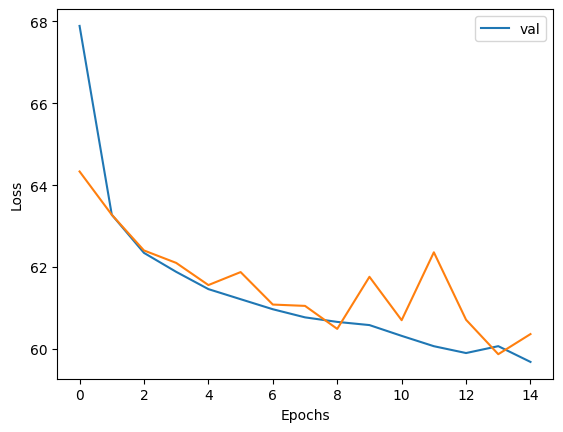

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

TOTAL TEST LOSS  59.93895513255422
TEST TEST TIME 31.175350189208984

 Experiment 2
Epoch n0




1it [00:00,  4.30it/s]

2it [00:00,  3.50it/s]

3it [00:00,  3.77it/s]

4it [00:01,  2.24it/s]

5it [00:01,  2.64it/s]

6it [00:02,  2.28it/s]

7it [00:02,  2.33it/s]

8it [00:03,  2.12it/s]

9it [00:03,  2.47it/s]

10it [00:04,  2.40it/s]

11it [00:04,  2.54it/s]

12it [00:05,  2.21it/s]

13it [00:05,  2.64it/s]

14it [00:05,  2.22it/s]

15it [00:06,  2.52it/s]

16it [00:06,  2.62it/s]

17it [00:06,  2.57it/s]

18it [00:07,  2.98it/s]

19it [00:07,  2.60it/s]

20it [00:07,  2.98it/s]

21it [00:08,  2.73it/s]

22it [00:08,  3.08it/s]

23it [00:08,  3.40it/s]

24it [00:09,  3.68it/s]

25it [00:09,  3.35it/s]

26it [00:09,  3.09it/s]

27it [00:10,  3.25it/s]

28it [00:10,  3.01it/s]

29it [00:10,  3.08it/s]

30it [00:11,  3.19it/s]

31it [00:11,  2.93it/s]

32it [00:11,  3.27it/s]

33it [00:12,  3.05it/s]

34it [00:13,  1.88it/s]

35it [00:13,  2.25it/s]

36it [00:13,  2.68it/s]

37it [00:13,  2.60it/s]

38it [00:14,  2.77it/s]

39it [00:14,  2.78it/s]

40it [00:14,  3.14it/s]

41it [0

TOTAL TRAIN LOSS 67.794797817416
TRAINING TIME 407.1926031112671



  7%|▋         | 1/15 [07:03<1:38:44, 423.15s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 64.04271400336063
EVAL TIME 15.927577257156372
** ** * Saving fine - tuned model ** ** * 


Epoch n1




1it [00:00,  4.28it/s]

2it [00:00,  4.32it/s]

3it [00:00,  4.42it/s]

4it [00:00,  4.58it/s]

5it [00:01,  3.88it/s]

6it [00:01,  3.99it/s]

7it [00:01,  3.90it/s]

8it [00:02,  3.79it/s]

9it [00:03,  1.88it/s]

10it [00:03,  2.24it/s]

11it [00:05,  1.25it/s]

12it [00:05,  1.48it/s]

13it [00:06,  1.48it/s]

14it [00:07,  1.13it/s]

15it [00:07,  1.31it/s]

16it [00:08,  1.65it/s]

17it [00:08,  2.03it/s]

18it [00:09,  1.76it/s]

19it [00:09,  2.17it/s]

20it [00:09,  2.24it/s]

21it [00:10,  2.61it/s]

22it [00:10,  2.11it/s]

23it [00:12,  1.25it/s]

24it [00:13,  1.09it/s]

25it [00:13,  1.34it/s]

26it [00:14,  1.69it/s]

27it [00:14,  2.04it/s]

28it [00:14,  2.06it/s]

29it [00:15,  2.07it/s]

30it [00:16,  1.46it/s]

31it [00:16,  1.72it/s]

32it [00:17,  1.60it/s]

33it [00:19,  1.08it/s]

34it [00:19,  1.31it/s]

35it [00:19,  1.50it/s]

36it [00:20,  1.57it/s]

37it [00:21,  1.51it/s]

38it [00:21,  1.88it/s]

39it [00:23,  1.12it/s]

40it [00:23,  1.45it/s]

41it [0

TOTAL TRAIN LOSS 63.19852382383422
TRAINING TIME 529.98486328125



 13%|█▎        | 2/15 [16:04<1:39:23, 458.72s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 62.69540016097252
EVAL TIME 11.739316940307617
** ** * Saving fine - tuned model ** ** * 


Epoch n2




1it [00:00,  4.57it/s]

2it [00:00,  4.49it/s]

3it [00:00,  4.42it/s]

4it [00:01,  3.96it/s]

5it [00:01,  3.40it/s]

6it [00:01,  3.57it/s]

7it [00:02,  1.95it/s]

8it [00:03,  1.44it/s]

9it [00:04,  1.75it/s]

10it [00:04,  1.77it/s]

11it [00:05,  1.66it/s]

12it [00:05,  2.06it/s]

13it [00:07,  1.13it/s]

14it [00:07,  1.37it/s]

15it [00:07,  1.71it/s]

16it [00:10,  1.07s/it]

17it [00:10,  1.18it/s]

18it [00:11,  1.34it/s]

19it [00:11,  1.68it/s]

20it [00:11,  2.07it/s]

21it [00:11,  2.23it/s]

22it [00:12,  2.60it/s]

23it [00:12,  2.87it/s]

24it [00:12,  3.22it/s]

25it [00:12,  3.04it/s]

26it [00:13,  3.24it/s]

27it [00:14,  1.66it/s]

28it [00:15,  1.73it/s]

29it [00:15,  1.93it/s]

30it [00:16,  1.58it/s]

31it [00:17,  1.43it/s]

32it [00:18,  1.30it/s]

33it [00:18,  1.52it/s]

34it [00:19,  1.50it/s]

35it [00:19,  1.85it/s]

36it [00:20,  1.55it/s]

37it [00:20,  1.92it/s]

38it [00:20,  2.29it/s]

39it [00:21,  2.37it/s]

40it [00:21,  2.12it/s]

41it [0

TOTAL TRAIN LOSS 62.17675077820688
TRAINING TIME 398.62446427345276



 20%|██        | 3/15 [22:54<1:28:46, 443.86s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 61.83120992448595
EVAL TIME 10.55033016204834
** ** * Saving fine - tuned model ** ** * 


Epoch n3




1it [00:00,  1.34it/s]

2it [00:02,  1.09s/it]

3it [00:04,  1.27s/it]

4it [00:04,  1.00s/it]

5it [00:04,  1.28it/s]

6it [00:05,  1.63it/s]

7it [00:05,  1.94it/s]

8it [00:05,  2.34it/s]

9it [00:06,  1.97it/s]

10it [00:06,  2.06it/s]

11it [00:07,  2.43it/s]

12it [00:07,  1.81it/s]

13it [00:08,  2.11it/s]

14it [00:08,  2.37it/s]

15it [00:08,  2.65it/s]

16it [00:09,  2.94it/s]

17it [00:09,  3.15it/s]

18it [00:09,  3.33it/s]

19it [00:09,  3.05it/s]

20it [00:10,  3.04it/s]

21it [00:10,  2.74it/s]

22it [00:11,  3.03it/s]

23it [00:11,  3.32it/s]

24it [00:11,  3.36it/s]

25it [00:11,  3.67it/s]

26it [00:12,  3.73it/s]

27it [00:12,  3.29it/s]

28it [00:12,  3.21it/s]

29it [00:12,  3.38it/s]

30it [00:13,  3.48it/s]

31it [00:13,  3.74it/s]

32it [00:13,  3.85it/s]

33it [00:13,  3.79it/s]

34it [00:14,  2.98it/s]

35it [00:14,  3.21it/s]

36it [00:15,  2.86it/s]

37it [00:15,  3.17it/s]

38it [00:15,  3.41it/s]

39it [00:15,  3.38it/s]

40it [00:16,  3.31it/s]

41it [0

TOTAL TRAIN LOSS 61.719655423580186
TRAINING TIME 261.37256121635437



 27%|██▋       | 4/15 [27:27<1:12:00, 392.74s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 61.98658109915377
EVAL TIME 12.06790018081665


Epoch n4




1it [00:00,  4.18it/s]

2it [00:00,  4.14it/s]

3it [00:00,  4.13it/s]

4it [00:00,  4.12it/s]

5it [00:01,  4.11it/s]

6it [00:01,  4.07it/s]

7it [00:01,  4.00it/s]

8it [00:01,  4.07it/s]

9it [00:02,  2.83it/s]

10it [00:02,  2.89it/s]

11it [00:03,  3.14it/s]

12it [00:03,  3.38it/s]

13it [00:03,  3.48it/s]

14it [00:03,  3.80it/s]

15it [00:04,  3.46it/s]

16it [00:04,  3.13it/s]

17it [00:05,  2.74it/s]

18it [00:05,  3.02it/s]

19it [00:05,  3.38it/s]

20it [00:05,  3.52it/s]

21it [00:06,  3.68it/s]

22it [00:06,  3.83it/s]

23it [00:06,  3.94it/s]

24it [00:06,  3.89it/s]

25it [00:07,  3.99it/s]

26it [00:07,  4.03it/s]

27it [00:07,  3.99it/s]

28it [00:07,  4.09it/s]

29it [00:08,  4.05it/s]

30it [00:08,  4.12it/s]

31it [00:08,  3.81it/s]

32it [00:08,  3.55it/s]

33it [00:09,  3.74it/s]

34it [00:09,  3.83it/s]

35it [00:09,  3.73it/s]

36it [00:09,  3.86it/s]

37it [00:10,  3.84it/s]

38it [00:10,  3.95it/s]

39it [00:10,  3.77it/s]

40it [00:10,  3.86it/s]

41it [0

TOTAL TRAIN LOSS 61.42480790817589
TRAINING TIME 237.49106192588806



 33%|███▎      | 5/15 [31:34<58:10, 349.04s/it]  

0it [00:00, ?it/s]

TOTAL VAL LOSS 62.0088709725274
EVAL TIME 9.579235792160034


Epoch n5




1it [00:00,  4.37it/s]

2it [00:00,  4.25it/s]

3it [00:00,  4.26it/s]

4it [00:00,  4.28it/s]

5it [00:01,  4.29it/s]

6it [00:01,  4.50it/s]

7it [00:01,  4.33it/s]

8it [00:01,  4.19it/s]

9it [00:02,  4.17it/s]

10it [00:02,  3.94it/s]

11it [00:02,  4.07it/s]

12it [00:02,  4.21it/s]

13it [00:03,  3.87it/s]

14it [00:03,  3.99it/s]

15it [00:03,  3.92it/s]

16it [00:03,  3.98it/s]

17it [00:04,  3.58it/s]

18it [00:04,  3.79it/s]

19it [00:04,  3.81it/s]

20it [00:05,  3.78it/s]

21it [00:05,  3.34it/s]

22it [00:05,  3.49it/s]

23it [00:06,  2.94it/s]

24it [00:06,  3.17it/s]

25it [00:06,  3.40it/s]

26it [00:06,  3.53it/s]

27it [00:07,  3.65it/s]

28it [00:07,  3.69it/s]

29it [00:07,  3.90it/s]

30it [00:07,  4.11it/s]

31it [00:08,  4.28it/s]

32it [00:08,  4.30it/s]

33it [00:08,  3.98it/s]

34it [00:08,  3.91it/s]

35it [00:09,  4.01it/s]

36it [00:09,  4.15it/s]

37it [00:09,  4.23it/s]

38it [00:09,  4.20it/s]

39it [00:10,  4.03it/s]

40it [00:10,  4.11it/s]

41it [0

TOTAL TRAIN LOSS 61.390206173889226
TRAINING TIME 242.73590183258057



 40%|████      | 6/15 [35:47<48:00, 320.07s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 61.18651717600196
EVAL TIME 9.71561598777771
** ** * Saving fine - tuned model ** ** * 


Epoch n6




1it [00:00,  4.50it/s]

2it [00:00,  4.40it/s]

3it [00:00,  4.38it/s]

4it [00:00,  4.32it/s]

5it [00:01,  4.34it/s]

6it [00:01,  4.48it/s]

7it [00:01,  4.37it/s]

8it [00:01,  3.76it/s]

9it [00:02,  3.82it/s]

10it [00:02,  3.82it/s]

11it [00:02,  3.99it/s]

12it [00:02,  4.05it/s]

13it [00:03,  4.10it/s]

14it [00:03,  4.21it/s]

15it [00:03,  4.02it/s]

16it [00:03,  3.90it/s]

17it [00:04,  3.96it/s]

18it [00:04,  4.08it/s]

19it [00:04,  4.12it/s]

20it [00:04,  4.01it/s]

21it [00:05,  4.05it/s]

22it [00:05,  4.11it/s]

23it [00:05,  3.86it/s]

24it [00:05,  3.93it/s]

25it [00:06,  4.08it/s]

26it [00:06,  3.91it/s]

27it [00:06,  3.79it/s]

28it [00:07,  3.24it/s]

29it [00:07,  3.46it/s]

30it [00:07,  3.36it/s]

31it [00:07,  3.56it/s]

32it [00:08,  3.76it/s]

33it [00:08,  3.92it/s]

34it [00:08,  3.97it/s]

35it [00:08,  4.01it/s]

36it [00:09,  3.84it/s]

37it [00:09,  3.86it/s]

38it [00:09,  3.97it/s]

39it [00:09,  3.94it/s]

40it [00:10,  4.05it/s]

41it [0

TOTAL TRAIN LOSS 60.95024235251266
TRAINING TIME 235.1086549758911



 47%|████▋     | 7/15 [39:52<39:40, 297.54s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 60.83440443482062
EVAL TIME 9.850611925125122
** ** * Saving fine - tuned model ** ** * 


Epoch n7




1it [00:00,  4.24it/s]

2it [00:00,  4.31it/s]

3it [00:00,  4.36it/s]

4it [00:00,  4.33it/s]

5it [00:01,  4.41it/s]

6it [00:01,  4.40it/s]

7it [00:01,  4.31it/s]

8it [00:01,  4.29it/s]

9it [00:02,  4.29it/s]

10it [00:02,  3.95it/s]

11it [00:02,  4.23it/s]

12it [00:02,  4.39it/s]

13it [00:02,  4.51it/s]

14it [00:03,  4.57it/s]

15it [00:03,  4.23it/s]

16it [00:03,  4.19it/s]

17it [00:03,  4.22it/s]

18it [00:04,  4.48it/s]

19it [00:04,  4.43it/s]

20it [00:04,  3.17it/s]

21it [00:05,  3.06it/s]

22it [00:05,  3.37it/s]

23it [00:05,  3.60it/s]

24it [00:05,  3.78it/s]

25it [00:06,  4.14it/s]

26it [00:06,  3.74it/s]

27it [00:06,  3.86it/s]

28it [00:06,  3.93it/s]

29it [00:07,  4.01it/s]

30it [00:07,  3.98it/s]

31it [00:07,  3.94it/s]

32it [00:07,  4.05it/s]

33it [00:08,  4.10it/s]

34it [00:08,  4.10it/s]

35it [00:08,  4.05it/s]

36it [00:08,  4.19it/s]

37it [00:09,  4.12it/s]

38it [00:09,  4.14it/s]

39it [00:09,  4.22it/s]

40it [00:09,  4.24it/s]

41it [0

TOTAL TRAIN LOSS 60.77773378227467
TRAINING TIME 230.4332571029663



 53%|█████▎    | 8/15 [43:52<32:42, 280.42s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 61.007848893753206
EVAL TIME 10.04380202293396


Epoch n8




1it [00:00,  4.37it/s]

2it [00:00,  4.22it/s]

3it [00:00,  3.79it/s]

4it [00:01,  4.01it/s]

5it [00:01,  4.01it/s]

6it [00:01,  4.16it/s]

7it [00:01,  3.98it/s]

8it [00:02,  3.92it/s]

9it [00:02,  4.04it/s]

10it [00:02,  3.97it/s]

11it [00:02,  4.01it/s]

12it [00:03,  4.10it/s]

13it [00:03,  3.93it/s]

14it [00:03,  4.10it/s]

15it [00:03,  3.40it/s]

16it [00:04,  3.38it/s]

17it [00:04,  3.63it/s]

18it [00:04,  3.78it/s]

19it [00:04,  3.92it/s]

20it [00:05,  4.00it/s]

21it [00:05,  4.15it/s]

22it [00:05,  4.25it/s]

23it [00:05,  4.27it/s]

24it [00:06,  3.31it/s]

25it [00:06,  3.66it/s]

26it [00:06,  3.64it/s]

27it [00:07,  3.79it/s]

28it [00:07,  3.88it/s]

29it [00:07,  3.99it/s]

30it [00:07,  4.11it/s]

31it [00:07,  4.33it/s]

32it [00:08,  4.27it/s]

33it [00:08,  4.31it/s]

34it [00:08,  4.38it/s]

35it [00:08,  4.35it/s]

36it [00:09,  4.54it/s]

37it [00:09,  4.25it/s]

38it [00:09,  4.25it/s]

39it [00:09,  4.32it/s]

40it [00:09,  4.34it/s]

41it [0

TOTAL TRAIN LOSS 60.81312241667664
TRAINING TIME 228.03886079788208



 60%|██████    | 9/15 [47:53<26:51, 268.53s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 59.544792271623706
EVAL TIME 12.734709024429321
** ** * Saving fine - tuned model ** ** * 


Epoch n9




1it [00:00,  4.25it/s]

2it [00:00,  4.40it/s]

3it [00:00,  4.33it/s]

4it [00:00,  4.61it/s]

5it [00:01,  4.64it/s]

6it [00:01,  4.48it/s]

7it [00:01,  4.42it/s]

8it [00:01,  4.53it/s]

9it [00:01,  4.52it/s]

10it [00:02,  4.32it/s]

11it [00:02,  4.24it/s]

12it [00:02,  4.26it/s]

13it [00:02,  4.30it/s]

14it [00:03,  4.48it/s]

15it [00:03,  4.42it/s]

16it [00:03,  4.14it/s]

17it [00:03,  4.10it/s]

18it [00:04,  4.17it/s]

19it [00:04,  4.13it/s]

20it [00:04,  4.22it/s]

21it [00:04,  4.17it/s]

22it [00:05,  4.35it/s]

23it [00:05,  4.42it/s]

24it [00:05,  4.22it/s]

25it [00:05,  4.39it/s]

26it [00:05,  4.52it/s]

27it [00:06,  4.46it/s]

28it [00:06,  4.68it/s]

29it [00:06,  4.60it/s]

30it [00:06,  4.25it/s]

31it [00:07,  4.21it/s]

32it [00:07,  4.32it/s]

33it [00:07,  4.29it/s]

34it [00:07,  4.23it/s]

35it [00:08,  3.66it/s]

36it [00:08,  3.40it/s]

37it [00:08,  3.47it/s]

38it [00:09,  3.51it/s]

39it [00:09,  3.76it/s]

40it [00:09,  3.71it/s]

41it [0

TOTAL TRAIN LOSS 60.407320883373984
TRAINING TIME 227.14211106300354



 67%|██████▋   | 10/15 [51:50<21:36, 259.22s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 60.75590109584307
EVAL TIME 10.333662033081055


Epoch n10




1it [00:00,  4.84it/s]

2it [00:00,  4.68it/s]

3it [00:00,  4.82it/s]

4it [00:00,  4.71it/s]

5it [00:01,  4.48it/s]

6it [00:01,  4.31it/s]

7it [00:01,  4.22it/s]

8it [00:01,  4.28it/s]

9it [00:02,  4.21it/s]

10it [00:02,  4.18it/s]

11it [00:02,  4.15it/s]

12it [00:02,  4.44it/s]

13it [00:02,  4.44it/s]

14it [00:03,  4.27it/s]

15it [00:03,  4.25it/s]

16it [00:03,  4.23it/s]

17it [00:03,  4.05it/s]

18it [00:04,  4.12it/s]

19it [00:04,  4.17it/s]

20it [00:04,  3.54it/s]

21it [00:05,  3.63it/s]

22it [00:05,  3.72it/s]

23it [00:05,  3.79it/s]

24it [00:05,  3.86it/s]

25it [00:06,  3.95it/s]

26it [00:06,  4.06it/s]

27it [00:06,  3.64it/s]

28it [00:06,  3.73it/s]

29it [00:07,  3.84it/s]

30it [00:07,  3.96it/s]

31it [00:07,  3.62it/s]

32it [00:07,  3.89it/s]

33it [00:08,  4.04it/s]

34it [00:08,  4.16it/s]

35it [00:08,  3.35it/s]

36it [00:09,  3.62it/s]

37it [00:09,  3.75it/s]

38it [00:09,  3.82it/s]

39it [00:09,  3.96it/s]

40it [00:10,  3.67it/s]

41it [0

TOTAL TRAIN LOSS 60.41578455932548
TRAINING TIME 236.07146501541138



 73%|███████▎  | 11/15 [55:56<17:00, 255.07s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 60.199644059845895
EVAL TIME 9.30782699584961


Epoch n11




1it [00:00,  4.02it/s]

2it [00:00,  3.84it/s]

3it [00:00,  3.88it/s]

4it [00:01,  3.97it/s]

5it [00:01,  4.06it/s]

6it [00:01,  4.15it/s]

7it [00:01,  4.16it/s]

8it [00:01,  4.19it/s]

9it [00:02,  4.17it/s]

10it [00:02,  3.26it/s]

11it [00:02,  3.60it/s]

12it [00:03,  3.65it/s]

13it [00:03,  3.82it/s]

14it [00:03,  4.04it/s]

15it [00:03,  4.04it/s]

16it [00:04,  4.09it/s]

17it [00:04,  4.29it/s]

18it [00:04,  4.37it/s]

19it [00:04,  3.97it/s]

20it [00:05,  3.97it/s]

21it [00:05,  4.06it/s]

22it [00:05,  4.08it/s]

23it [00:05,  4.06it/s]

24it [00:05,  4.25it/s]

25it [00:06,  4.36it/s]

26it [00:06,  4.27it/s]

27it [00:06,  4.26it/s]

28it [00:06,  4.33it/s]

29it [00:07,  4.31it/s]

30it [00:07,  4.26it/s]

31it [00:07,  4.36it/s]

32it [00:07,  4.39it/s]

33it [00:08,  4.43it/s]

34it [00:08,  4.34it/s]

35it [00:08,  4.36it/s]

36it [00:08,  4.16it/s]

37it [00:09,  4.05it/s]

38it [00:09,  3.91it/s]

39it [00:09,  4.01it/s]

40it [00:09,  4.10it/s]

41it [0

TOTAL TRAIN LOSS 60.029947593015024
TRAINING TIME 237.5978798866272



 80%|████████  | 12/15 [1:00:03<12:38, 252.89s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 59.881778148689655
EVAL TIME 10.208836793899536


Epoch n12




1it [00:00,  4.10it/s]

2it [00:00,  3.67it/s]

3it [00:00,  3.76it/s]

4it [00:01,  3.59it/s]

5it [00:01,  3.69it/s]

6it [00:01,  3.78it/s]

7it [00:01,  4.10it/s]

8it [00:02,  4.17it/s]

9it [00:02,  4.28it/s]

10it [00:02,  4.34it/s]

11it [00:02,  4.47it/s]

12it [00:02,  4.60it/s]

13it [00:03,  4.50it/s]

14it [00:03,  4.60it/s]

15it [00:03,  4.43it/s]

16it [00:03,  4.06it/s]

17it [00:04,  4.31it/s]

18it [00:04,  4.24it/s]

19it [00:04,  4.45it/s]

20it [00:04,  4.35it/s]

21it [00:05,  3.31it/s]

22it [00:05,  3.52it/s]

23it [00:05,  3.81it/s]

24it [00:05,  3.93it/s]

25it [00:06,  4.19it/s]

26it [00:06,  4.22it/s]

27it [00:06,  4.12it/s]

28it [00:06,  4.04it/s]

29it [00:07,  3.54it/s]

30it [00:07,  3.72it/s]

31it [00:08,  2.91it/s]

32it [00:10,  1.07it/s]

33it [00:10,  1.36it/s]

34it [00:10,  1.70it/s]

35it [00:11,  2.05it/s]

36it [00:11,  2.42it/s]

37it [00:11,  2.80it/s]

38it [00:11,  3.13it/s]

39it [00:12,  3.38it/s]

40it [00:12,  3.65it/s]

41it [0

TOTAL TRAIN LOSS 60.05137184333153
TRAINING TIME 236.32266998291016



 87%|████████▋ | 13/15 [1:04:10<08:22, 251.05s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 59.88159145971741
EVAL TIME 10.444581270217896


Epoch n13




1it [00:00,  4.43it/s]

2it [00:00,  4.46it/s]

3it [00:00,  4.21it/s]

4it [00:00,  4.30it/s]

5it [00:01,  3.71it/s]

6it [00:01,  3.98it/s]

7it [00:01,  4.07it/s]

8it [00:01,  4.29it/s]

9it [00:02,  4.32it/s]

10it [00:02,  3.21it/s]

11it [00:02,  3.54it/s]

12it [00:03,  3.80it/s]

13it [00:03,  3.91it/s]

14it [00:03,  4.03it/s]

15it [00:03,  4.06it/s]

16it [00:04,  4.04it/s]

17it [00:04,  4.04it/s]

18it [00:04,  3.98it/s]

19it [00:04,  3.62it/s]

20it [00:05,  3.49it/s]

21it [00:05,  3.67it/s]

22it [00:05,  3.82it/s]

23it [00:05,  3.73it/s]

24it [00:06,  3.83it/s]

25it [00:06,  3.79it/s]

26it [00:06,  3.80it/s]

27it [00:07,  3.80it/s]

28it [00:07,  3.91it/s]

29it [00:07,  4.01it/s]

30it [00:07,  4.15it/s]

31it [00:07,  3.92it/s]

32it [00:08,  3.98it/s]

33it [00:08,  4.04it/s]

34it [00:08,  3.93it/s]

35it [00:08,  4.04it/s]

36it [00:09,  3.22it/s]

37it [00:09,  3.13it/s]

38it [00:10,  3.28it/s]

39it [00:10,  3.50it/s]

40it [00:10,  3.67it/s]

41it [0

TOTAL TRAIN LOSS 60.035275851343656
TRAINING TIME 228.40346479415894



 93%|█████████▎| 14/15 [1:08:09<04:07, 247.30s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 60.90252259765008
EVAL TIME 10.122390985488892


Epoch n14




1it [00:00,  4.74it/s]

2it [00:00,  4.03it/s]

3it [00:00,  4.22it/s]

4it [00:00,  4.46it/s]

5it [00:01,  4.48it/s]

6it [00:01,  4.16it/s]

7it [00:01,  4.14it/s]

8it [00:01,  4.21it/s]

9it [00:02,  4.23it/s]

10it [00:02,  3.85it/s]

11it [00:02,  3.42it/s]

12it [00:03,  3.06it/s]

13it [00:03,  3.28it/s]

14it [00:04,  2.45it/s]

15it [00:04,  2.69it/s]

16it [00:04,  2.96it/s]

17it [00:04,  3.24it/s]

18it [00:05,  3.32it/s]

19it [00:05,  3.53it/s]

20it [00:05,  3.72it/s]

21it [00:05,  4.00it/s]

22it [00:06,  4.16it/s]

23it [00:06,  4.44it/s]

24it [00:06,  4.42it/s]

25it [00:06,  4.27it/s]

26it [00:07,  4.15it/s]

27it [00:07,  4.27it/s]

28it [00:07,  4.36it/s]

29it [00:07,  4.52it/s]

30it [00:07,  4.64it/s]

31it [00:08,  4.57it/s]

32it [00:08,  4.75it/s]

33it [00:08,  4.67it/s]

34it [00:08,  4.32it/s]

35it [00:09,  4.36it/s]

36it [00:09,  4.38it/s]

37it [00:09,  4.58it/s]

38it [00:09,  4.60it/s]

39it [00:09,  4.57it/s]

40it [00:10,  4.79it/s]

41it [0

TOTAL TRAIN LOSS 59.85774308071806
TRAINING TIME 223.61843514442444



100%|██████████| 15/15 [1:12:03<00:00, 288.25s/it]

TOTAL VAL LOSS 59.9306239022149
EVAL TIME 10.844733953475952


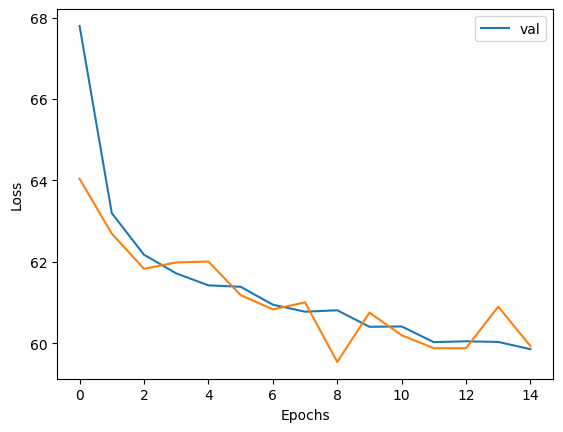

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

TOTAL TEST LOSS  59.58852744683987
TEST TEST TIME 27.37226915359497

 Experiment 3
Epoch n0




1it [00:00,  4.24it/s]

2it [00:00,  3.89it/s]

3it [00:00,  3.77it/s]

4it [00:01,  3.87it/s]

5it [00:01,  4.02it/s]

6it [00:01,  3.72it/s]

7it [00:01,  3.61it/s]

8it [00:02,  3.76it/s]

9it [00:02,  3.70it/s]

10it [00:02,  3.68it/s]

11it [00:02,  3.89it/s]

12it [00:03,  3.94it/s]

13it [00:03,  3.93it/s]

14it [00:03,  4.00it/s]

15it [00:03,  4.11it/s]

16it [00:04,  4.06it/s]

17it [00:04,  3.80it/s]

18it [00:04,  3.87it/s]

19it [00:04,  3.86it/s]

20it [00:05,  3.79it/s]

21it [00:05,  3.68it/s]

22it [00:05,  3.77it/s]

23it [00:06,  3.86it/s]

24it [00:06,  3.88it/s]

25it [00:06,  3.99it/s]

26it [00:06,  3.94it/s]

27it [00:07,  3.79it/s]

28it [00:07,  3.90it/s]

29it [00:07,  3.92it/s]

30it [00:07,  3.94it/s]

31it [00:08,  3.89it/s]

32it [00:08,  4.02it/s]

33it [00:08,  4.14it/s]

34it [00:08,  3.78it/s]

35it [00:09,  3.81it/s]

36it [00:09,  3.76it/s]

37it [00:09,  3.89it/s]

38it [00:09,  3.93it/s]

39it [00:10,  3.84it/s]

40it [00:10,  3.97it/s]

41it [0

TOTAL TRAIN LOSS 67.6343010074015
TRAINING TIME 237.92336916923523



  7%|▋         | 1/15 [04:08<57:57, 248.38s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 63.90166407883769
EVAL TIME 10.430710077285767
** ** * Saving fine - tuned model ** ** * 


Epoch n1




1it [00:00,  4.71it/s]

2it [00:00,  4.26it/s]

3it [00:00,  4.15it/s]

4it [00:01,  3.82it/s]

5it [00:01,  3.99it/s]

6it [00:01,  4.02it/s]

7it [00:01,  3.86it/s]

8it [00:02,  3.90it/s]

9it [00:02,  3.32it/s]

10it [00:02,  3.00it/s]

11it [00:03,  3.26it/s]

12it [00:03,  3.42it/s]

13it [00:03,  3.42it/s]

14it [00:03,  3.70it/s]

15it [00:04,  3.67it/s]

16it [00:04,  3.57it/s]

17it [00:04,  3.67it/s]

18it [00:05,  3.53it/s]

19it [00:05,  3.68it/s]

20it [00:05,  3.81it/s]

21it [00:05,  3.92it/s]

22it [00:06,  3.93it/s]

23it [00:06,  4.02it/s]

24it [00:06,  3.95it/s]

25it [00:06,  3.97it/s]

26it [00:07,  3.90it/s]

27it [00:07,  4.04it/s]

28it [00:07,  4.22it/s]

29it [00:07,  3.46it/s]

30it [00:08,  3.63it/s]

31it [00:08,  3.63it/s]

32it [00:08,  3.81it/s]

33it [00:08,  3.94it/s]

34it [00:09,  3.75it/s]

35it [00:09,  3.67it/s]

36it [00:09,  3.87it/s]

37it [00:09,  3.90it/s]

38it [00:10,  4.11it/s]

39it [00:10,  4.22it/s]

40it [00:10,  4.22it/s]

41it [0

TOTAL TRAIN LOSS 63.364517162232275
TRAINING TIME 258.79376697540283



 13%|█▎        | 2/15 [08:36<55:05, 254.24s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 62.08357974736377
EVAL TIME 9.098390102386475
** ** * Saving fine - tuned model ** ** * 


Epoch n2




1it [00:00,  4.59it/s]

2it [00:00,  4.03it/s]

3it [00:00,  4.00it/s]

4it [00:01,  4.18it/s]

5it [00:01,  4.25it/s]

6it [00:01,  4.25it/s]

7it [00:01,  4.32it/s]

8it [00:01,  4.31it/s]

9it [00:02,  4.34it/s]

10it [00:02,  3.80it/s]

11it [00:02,  3.94it/s]

12it [00:02,  3.93it/s]

13it [00:03,  3.90it/s]

14it [00:03,  3.93it/s]

15it [00:03,  3.83it/s]

16it [00:04,  3.76it/s]

17it [00:04,  3.99it/s]

18it [00:04,  4.06it/s]

19it [00:04,  4.14it/s]

20it [00:04,  4.17it/s]

21it [00:05,  4.40it/s]

22it [00:05,  4.39it/s]

23it [00:05,  4.49it/s]

24it [00:05,  4.59it/s]

25it [00:06,  4.52it/s]

26it [00:06,  4.27it/s]

27it [00:06,  4.41it/s]

28it [00:06,  4.65it/s]

29it [00:06,  4.43it/s]

30it [00:07,  4.19it/s]

31it [00:07,  4.45it/s]

32it [00:07,  4.47it/s]

33it [00:07,  4.49it/s]

34it [00:08,  4.51it/s]

35it [00:08,  4.56it/s]

36it [00:08,  4.83it/s]

37it [00:08,  4.40it/s]

38it [00:09,  4.15it/s]

39it [00:09,  4.02it/s]

40it [00:09,  4.13it/s]

41it [0

TOTAL TRAIN LOSS 62.30489381982408
TRAINING TIME 225.2998230457306



 20%|██        | 3/15 [12:33<49:50, 249.20s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 62.844086993824355
EVAL TIME 12.14652395248413


Epoch n3




1it [00:00,  4.21it/s]

2it [00:00,  3.42it/s]

3it [00:00,  3.52it/s]

4it [00:01,  3.59it/s]

5it [00:01,  3.81it/s]

6it [00:01,  3.81it/s]

7it [00:01,  3.81it/s]

8it [00:02,  3.90it/s]

9it [00:02,  4.14it/s]

10it [00:02,  4.04it/s]

11it [00:02,  3.68it/s]

12it [00:03,  3.81it/s]

13it [00:03,  4.02it/s]

14it [00:03,  4.15it/s]

15it [00:03,  4.19it/s]

16it [00:04,  4.12it/s]

17it [00:04,  4.44it/s]

18it [00:04,  4.55it/s]

19it [00:04,  3.65it/s]

20it [00:05,  3.74it/s]

21it [00:05,  3.85it/s]

22it [00:05,  3.94it/s]

23it [00:05,  4.09it/s]

24it [00:06,  4.17it/s]

25it [00:06,  4.27it/s]

26it [00:06,  4.31it/s]

27it [00:06,  4.45it/s]

28it [00:07,  4.40it/s]

29it [00:07,  4.36it/s]

30it [00:07,  4.36it/s]

31it [00:07,  4.36it/s]

32it [00:08,  3.91it/s]

33it [00:08,  4.17it/s]

34it [00:08,  4.17it/s]

35it [00:08,  4.27it/s]

36it [00:08,  4.20it/s]

37it [00:09,  4.28it/s]

38it [00:09,  4.29it/s]

39it [00:09,  4.25it/s]

40it [00:09,  4.13it/s]

41it [0

TOTAL TRAIN LOSS 61.75134615611922
TRAINING TIME 229.08210611343384



 27%|██▋       | 4/15 [16:32<45:07, 246.18s/it]

0it [00:00, ?it/s]



TOTAL VAL LOSS 61.13913714283645
EVAL TIME 10.013015747070312
** ** * Saving fine - tuned model ** ** * 


Epoch n4


1it [00:00,  5.45it/s]

2it [00:00,  4.68it/s]

3it [00:00,  4.37it/s]

4it [00:00,  4.37it/s]

5it [00:01,  4.48it/s]

6it [00:01,  4.38it/s]

7it [00:01,  4.49it/s]

8it [00:01,  4.18it/s]

9it [00:02,  3.71it/s]

10it [00:02,  3.70it/s]

11it [00:02,  3.50it/s]

12it [00:03,  3.68it/s]

13it [00:03,  3.64it/s]

14it [00:03,  3.46it/s]

15it [00:03,  3.64it/s]

16it [00:04,  3.66it/s]

17it [00:04,  3.84it/s]

18it [00:04,  3.99it/s]

19it [00:05,  3.54it/s]

20it [00:05,  3.61it/s]

21it [00:05,  3.77it/s]

22it [00:05,  3.29it/s]

23it [00:06,  3.59it/s]

24it [00:06,  3.87it/s]

25it [00:06,  4.14it/s]

26it [00:06,  4.38it/s]

27it [00:06,  4.49it/s]

28it [00:07,  4.55it/s]

29it [00:07,  4.67it/s]

30it [00:07,  4.63it/s]

31it [00:07,  4.37it/s]

32it [00:08,  4.25it/s]

33it [00:08,  4.33it/s]

34it [00:08,  4.33it/s]

35it [00:08,  4.30it/s]

36it [00:09,  4.31it/s]

37it [00:09,  4.25it/s]

38it [00:09,  4.40it/s]

39it [00:09,  4.21it/s]

40it [00:09,  4.16it/s]

41it [00:

TOTAL TRAIN LOSS 61.56512611989662
TRAINING TIME 289.913311958313



 33%|███▎      | 5/15 [21:43<44:14, 265.45s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 60.83295220076436
EVAL TIME 20.499645233154297
** ** * Saving fine - tuned model ** ** * 


Epoch n5




1it [00:00,  4.14it/s]

2it [00:01,  2.48it/s]

3it [00:03,  1.13s/it]

4it [00:04,  1.16it/s]

5it [00:06,  1.41s/it]

6it [00:07,  1.06s/it]

7it [00:07,  1.25it/s]

8it [00:07,  1.61it/s]

9it [00:08,  1.31it/s]

10it [00:08,  1.64it/s]

11it [00:10,  1.16it/s]

12it [00:10,  1.34it/s]

13it [00:10,  1.68it/s]

14it [00:11,  1.39it/s]

15it [00:12,  1.75it/s]

16it [00:12,  1.84it/s]

17it [00:13,  1.93it/s]

18it [00:13,  1.86it/s]

19it [00:13,  2.26it/s]

20it [00:14,  2.72it/s]

21it [00:14,  2.61it/s]

22it [00:17,  1.14s/it]

23it [00:17,  1.08it/s]

24it [00:19,  1.13s/it]

25it [00:20,  1.02it/s]

26it [00:20,  1.07it/s]

27it [00:21,  1.08it/s]

28it [00:22,  1.35it/s]

29it [00:23,  1.26it/s]

30it [00:23,  1.42it/s]

31it [00:23,  1.70it/s]

32it [00:24,  2.07it/s]

33it [00:25,  1.49it/s]

34it [00:25,  1.43it/s]

35it [00:27,  1.10it/s]

36it [00:28,  1.06it/s]

37it [00:28,  1.27it/s]

38it [00:29,  1.12it/s]

39it [00:31,  1.10s/it]

40it [00:31,  1.21it/s]

41it [0

TOTAL TRAIN LOSS 61.34185228315377
TRAINING TIME 549.0334510803223



 40%|████      | 6/15 [31:04<53:08, 354.30s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 61.19226287109683
EVAL TIME 12.573966026306152


Epoch n6




1it [00:00,  3.26it/s]

2it [00:01,  2.07it/s]

3it [00:01,  2.42it/s]

4it [00:01,  2.79it/s]

5it [00:01,  3.17it/s]

6it [00:02,  2.55it/s]

7it [00:02,  2.45it/s]

8it [00:03,  2.76it/s]

9it [00:03,  2.94it/s]

10it [00:05,  1.28it/s]

11it [00:05,  1.62it/s]

12it [00:07,  1.12it/s]

13it [00:07,  1.45it/s]

14it [00:08,  1.25it/s]

15it [00:08,  1.58it/s]

16it [00:10,  1.02it/s]

17it [00:10,  1.33it/s]

18it [00:11,  1.44it/s]

19it [00:11,  1.83it/s]

20it [00:11,  2.07it/s]

21it [00:12,  1.94it/s]

22it [00:12,  1.74it/s]

23it [00:13,  1.55it/s]

24it [00:14,  1.88it/s]

25it [00:15,  1.19it/s]

26it [00:16,  1.06it/s]

27it [00:17,  1.13it/s]

28it [00:18,  1.16it/s]

29it [00:19,  1.21it/s]

30it [00:19,  1.54it/s]

31it [00:19,  1.91it/s]

32it [00:19,  2.32it/s]

33it [00:21,  1.45it/s]

34it [00:21,  1.82it/s]

35it [00:22,  1.65it/s]

36it [00:22,  1.87it/s]

37it [00:22,  2.23it/s]

38it [00:23,  1.49it/s]

39it [00:25,  1.17it/s]

40it [00:25,  1.38it/s]

41it [0

TOTAL TRAIN LOSS 61.08194751350688
TRAINING TIME 594.4260642528534



 47%|████▋     | 7/15 [41:15<57:28, 431.06s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 60.68976989900223
EVAL TIME 15.726037979125977
** ** * Saving fine - tuned model ** ** * 


Epoch n7




1it [00:00,  5.01it/s]

2it [00:00,  4.62it/s]

3it [00:00,  4.47it/s]

4it [00:00,  4.49it/s]

5it [00:01,  4.58it/s]

6it [00:01,  3.75it/s]

7it [00:01,  4.07it/s]

8it [00:02,  2.55it/s]

9it [00:02,  2.85it/s]

10it [00:02,  3.10it/s]

11it [00:03,  2.59it/s]

12it [00:04,  1.91it/s]

13it [00:04,  1.78it/s]

14it [00:06,  1.10it/s]

15it [00:07,  1.30it/s]

16it [00:09,  1.20s/it]

17it [00:09,  1.11it/s]

18it [00:09,  1.44it/s]

19it [00:09,  1.84it/s]

20it [00:10,  2.26it/s]

21it [00:11,  1.48it/s]

22it [00:11,  1.77it/s]

23it [00:13,  1.01it/s]

24it [00:13,  1.31it/s]

25it [00:14,  1.19it/s]

26it [00:15,  1.40it/s]

27it [00:17,  1.12s/it]

28it [00:21,  1.87s/it]

29it [00:22,  1.62s/it]

30it [00:22,  1.36s/it]

31it [00:23,  1.02s/it]

32it [00:24,  1.01s/it]

33it [00:24,  1.04it/s]

34it [00:25,  1.12it/s]

35it [00:27,  1.08s/it]

36it [00:27,  1.13it/s]

37it [00:28,  1.28it/s]

38it [00:28,  1.63it/s]

39it [00:29,  1.42it/s]

40it [00:29,  1.78it/s]

41it [0

TOTAL TRAIN LOSS 60.96852764807903
TRAINING TIME 720.704375743866



 53%|█████▎    | 8/15 [53:38<1:01:13, 524.72s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 60.076903670725194
EVAL TIME 22.536081075668335
** ** * Saving fine - tuned model ** ** * 


Epoch n8




1it [00:00,  3.46it/s]

2it [00:01,  1.80it/s]

3it [00:02,  1.79it/s]

4it [00:02,  1.89it/s]

5it [00:05,  1.18s/it]

6it [00:05,  1.12it/s]

7it [00:07,  1.16s/it]

8it [00:07,  1.07it/s]

9it [00:09,  1.19s/it]

10it [00:12,  1.71s/it]

11it [00:15,  2.02s/it]

12it [00:15,  1.69s/it]

13it [00:16,  1.33s/it]

14it [00:18,  1.68s/it]

15it [00:19,  1.25s/it]

16it [00:20,  1.14s/it]

17it [00:22,  1.47s/it]

18it [00:22,  1.15s/it]

19it [00:23,  1.04it/s]

20it [00:25,  1.28s/it]

21it [00:26,  1.14s/it]

22it [00:27,  1.28s/it]

23it [00:29,  1.36s/it]

24it [00:30,  1.24s/it]

25it [00:30,  1.02it/s]

26it [00:31,  1.18it/s]

27it [00:31,  1.43it/s]

28it [00:31,  1.58it/s]

29it [00:32,  1.67it/s]

30it [00:32,  1.92it/s]

31it [00:34,  1.16it/s]

32it [00:34,  1.48it/s]

33it [00:35,  1.19it/s]

34it [00:37,  1.09it/s]

35it [00:39,  1.36s/it]

36it [00:42,  1.75s/it]

37it [00:42,  1.45s/it]

38it [00:43,  1.30s/it]

39it [00:44,  1.04s/it]

40it [00:44,  1.25it/s]

41it [0

TOTAL TRAIN LOSS 60.46674327159117
TRAINING TIME 789.6909229755402



 60%|██████    | 9/15 [1:07:02<1:00:50, 608.43s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 60.93204199665725
EVAL TIME 14.07728886604309


Epoch n9




1it [00:00,  4.79it/s]

2it [00:00,  3.70it/s]

3it [00:02,  1.61it/s]

4it [00:02,  1.96it/s]

5it [00:02,  2.14it/s]

6it [00:03,  2.19it/s]

7it [00:03,  2.24it/s]

8it [00:03,  2.64it/s]

9it [00:05,  1.55it/s]

10it [00:05,  1.77it/s]

11it [00:05,  1.84it/s]

12it [00:06,  2.25it/s]

13it [00:06,  2.64it/s]

14it [00:06,  2.86it/s]

15it [00:06,  3.03it/s]

16it [00:07,  3.24it/s]

17it [00:07,  3.56it/s]

18it [00:07,  3.75it/s]

19it [00:08,  3.27it/s]

20it [00:08,  2.40it/s]

21it [00:09,  1.68it/s]

22it [00:09,  2.08it/s]

23it [00:10,  2.48it/s]

24it [00:10,  2.21it/s]

25it [00:11,  1.82it/s]

26it [00:11,  1.97it/s]

27it [00:14,  1.01s/it]

28it [00:14,  1.14it/s]

29it [00:14,  1.46it/s]

30it [00:15,  1.65it/s]

31it [00:16,  1.55it/s]

32it [00:16,  1.75it/s]

33it [00:16,  2.13it/s]

34it [00:16,  2.33it/s]

35it [00:17,  1.86it/s]

36it [00:18,  1.37it/s]

37it [00:21,  1.14s/it]

38it [00:21,  1.08it/s]

39it [00:23,  1.36s/it]

40it [00:24,  1.02s/it]

41it [0

TOTAL TRAIN LOSS 60.719722043617395
TRAINING TIME 713.8421761989594



 67%|██████▋   | 10/15 [1:19:17<53:51, 646.39s/it] 

0it [00:00, ?it/s]

TOTAL VAL LOSS 60.22221343685882
EVAL TIME 21.10688281059265


Epoch n10




1it [00:00,  4.23it/s]

2it [00:00,  3.49it/s]

3it [00:01,  2.56it/s]

4it [00:01,  2.50it/s]

5it [00:02,  1.85it/s]

6it [00:02,  2.18it/s]

7it [00:03,  2.24it/s]

8it [00:04,  1.62it/s]

9it [00:06,  1.14s/it]

10it [00:07,  1.08it/s]

11it [00:07,  1.39it/s]

12it [00:07,  1.72it/s]

13it [00:08,  1.82it/s]

14it [00:08,  1.97it/s]

15it [00:08,  2.27it/s]

16it [00:08,  2.57it/s]

17it [00:09,  1.83it/s]

18it [00:11,  1.14it/s]

19it [00:13,  1.19s/it]

20it [00:14,  1.11s/it]

21it [00:16,  1.54s/it]

22it [00:17,  1.25s/it]

23it [00:18,  1.17s/it]

24it [00:18,  1.08it/s]

25it [00:19,  1.08it/s]

26it [00:20,  1.34it/s]

27it [00:20,  1.68it/s]

28it [00:20,  1.90it/s]

29it [00:23,  1.12s/it]

30it [00:24,  1.05s/it]

31it [00:24,  1.06it/s]

32it [00:26,  1.10s/it]

33it [00:27,  1.18s/it]

34it [00:28,  1.07s/it]

35it [00:28,  1.12it/s]

36it [00:29,  1.37it/s]

37it [00:29,  1.71it/s]

38it [00:29,  1.92it/s]

39it [00:30,  2.26it/s]

40it [00:30,  2.45it/s]

41it [0

TOTAL TRAIN LOSS 60.05184686062425
TRAINING TIME 753.7841982841492



 73%|███████▎  | 11/15 [1:32:10<45:37, 684.46s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 60.13836412718802
EVAL TIME 19.506667137145996


Epoch n11




1it [00:00,  4.69it/s]

2it [00:01,  2.55it/s]

3it [00:01,  2.29it/s]

4it [00:01,  2.46it/s]

5it [00:02,  2.53it/s]

6it [00:04,  1.01it/s]

7it [00:06,  1.30s/it]

8it [00:07,  1.27s/it]

9it [00:08,  1.05s/it]

10it [00:09,  1.05it/s]

11it [00:10,  1.05s/it]

12it [00:10,  1.16it/s]

13it [00:11,  1.51it/s]

14it [00:11,  1.59it/s]

15it [00:11,  1.95it/s]

16it [00:12,  2.20it/s]

17it [00:12,  2.63it/s]

18it [00:12,  2.76it/s]

19it [00:12,  3.05it/s]

20it [00:13,  3.24it/s]

21it [00:13,  2.54it/s]

22it [00:15,  1.17it/s]

23it [00:15,  1.47it/s]

24it [00:16,  1.65it/s]

25it [00:16,  1.92it/s]

26it [00:17,  1.44it/s]

27it [00:18,  1.68it/s]

28it [00:19,  1.27it/s]

29it [00:20,  1.25it/s]

30it [00:21,  1.06s/it]

31it [00:22,  1.17it/s]

32it [00:23,  1.21it/s]

33it [00:24,  1.00s/it]

34it [00:24,  1.29it/s]

35it [00:25,  1.49it/s]

36it [00:27,  1.03s/it]

37it [00:27,  1.06it/s]

38it [00:29,  1.06s/it]

39it [00:29,  1.22it/s]

40it [00:31,  1.19s/it]

41it [0

TOTAL TRAIN LOSS 60.07602874176958
TRAINING TIME 831.5071227550507



 80%|████████  | 12/15 [1:46:21<36:43, 734.52s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 59.346310682971065
EVAL TIME 19.791555166244507
** ** * Saving fine - tuned model ** ** * 


Epoch n12




1it [00:00,  4.52it/s]

2it [00:00,  4.13it/s]

3it [00:00,  3.92it/s]

4it [00:01,  3.82it/s]

5it [00:03,  1.24it/s]

6it [00:05,  1.22s/it]

7it [00:06,  1.09s/it]

8it [00:06,  1.15it/s]

9it [00:07,  1.12it/s]

10it [00:08,  1.24it/s]

11it [00:10,  1.36s/it]

12it [00:11,  1.23s/it]

13it [00:13,  1.38s/it]

14it [00:14,  1.26s/it]

15it [00:14,  1.01it/s]

16it [00:14,  1.29it/s]

17it [00:16,  1.04s/it]

18it [00:16,  1.26it/s]

19it [00:19,  1.25s/it]

20it [00:19,  1.02it/s]

21it [00:19,  1.20it/s]

22it [00:20,  1.50it/s]

23it [00:21,  1.31it/s]

24it [00:21,  1.62it/s]

25it [00:23,  1.13it/s]

26it [00:23,  1.30it/s]

27it [00:23,  1.57it/s]

28it [00:24,  1.80it/s]

29it [00:25,  1.09it/s]

30it [00:26,  1.31it/s]

31it [00:26,  1.64it/s]

32it [00:27,  1.40it/s]

33it [00:30,  1.38s/it]

34it [00:31,  1.34s/it]

35it [00:33,  1.36s/it]

36it [00:33,  1.13s/it]

37it [00:34,  1.05it/s]

38it [00:34,  1.30it/s]

39it [00:35,  1.21it/s]

40it [00:35,  1.54it/s]

41it [0

TOTAL TRAIN LOSS 59.890299567009826
TRAINING TIME 749.4876117706299



 87%|████████▋ | 13/15 [1:59:12<24:50, 745.41s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 59.976576361993345
EVAL TIME 21.330310821533203


Epoch n13




1it [00:00,  4.58it/s]

2it [00:03,  1.07s/it]

3it [00:04,  1.19s/it]

4it [00:05,  1.03s/it]

5it [00:06,  1.08it/s]

6it [00:06,  1.19it/s]

7it [00:07,  1.33it/s]

8it [00:10,  1.37s/it]

9it [00:10,  1.13s/it]

10it [00:11,  1.08it/s]

11it [00:11,  1.24it/s]

12it [00:11,  1.49it/s]

13it [00:12,  1.84it/s]

14it [00:12,  2.03it/s]

15it [00:13,  2.07it/s]

16it [00:14,  1.41it/s]

17it [00:14,  1.64it/s]

18it [00:14,  2.01it/s]

19it [00:15,  1.69it/s]

20it [00:16,  1.33it/s]

21it [00:17,  1.60it/s]

22it [00:19,  1.09s/it]

23it [00:22,  1.58s/it]

24it [00:23,  1.62s/it]

25it [00:24,  1.35s/it]

26it [00:25,  1.17s/it]

27it [00:26,  1.07s/it]

28it [00:26,  1.07it/s]

29it [00:27,  1.08it/s]

30it [00:28,  1.10it/s]

31it [00:29,  1.22it/s]

32it [00:29,  1.45it/s]

33it [00:30,  1.48it/s]

34it [00:30,  1.40it/s]

35it [00:32,  1.07s/it]

36it [00:35,  1.50s/it]

37it [00:36,  1.32s/it]

38it [00:37,  1.15s/it]

39it [00:39,  1.60s/it]

40it [00:40,  1.26s/it]

41it [0

TOTAL TRAIN LOSS 60.00177427704445
TRAINING TIME 795.527281999588



 93%|█████████▎| 14/15 [2:12:50<12:47, 767.32s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 59.626203161297425
EVAL TIME 22.910670042037964


Epoch n14




1it [00:00,  3.70it/s]

2it [00:00,  3.04it/s]

3it [00:01,  3.10it/s]

4it [00:01,  2.37it/s]

5it [00:05,  1.30s/it]

6it [00:06,  1.46s/it]

7it [00:07,  1.13s/it]

8it [00:07,  1.09it/s]

9it [00:08,  1.21it/s]

10it [00:08,  1.47it/s]

11it [00:08,  1.83it/s]

12it [00:09,  1.72it/s]

13it [00:10,  1.21it/s]

14it [00:13,  1.24s/it]

15it [00:13,  1.03it/s]

16it [00:14,  1.12it/s]

17it [00:14,  1.16it/s]

18it [00:16,  1.09it/s]

19it [00:16,  1.37it/s]

20it [00:18,  1.03s/it]

21it [00:18,  1.14it/s]

22it [00:21,  1.35s/it]

23it [00:21,  1.03s/it]

24it [00:22,  1.05s/it]

25it [00:22,  1.11it/s]

26it [00:23,  1.26it/s]

27it [00:23,  1.52it/s]

28it [00:24,  1.65it/s]

29it [00:24,  1.82it/s]

30it [00:25,  1.75it/s]

31it [00:25,  2.12it/s]

32it [00:25,  2.29it/s]

33it [00:26,  2.33it/s]

34it [00:26,  2.24it/s]

35it [00:27,  2.64it/s]

36it [00:27,  2.37it/s]

37it [00:27,  2.57it/s]

38it [00:28,  2.93it/s]

39it [00:29,  1.87it/s]

40it [00:30,  1.50it/s]

41it [0

TOTAL TRAIN LOSS 59.95300831908143
TRAINING TIME 758.3050072193146



100%|██████████| 15/15 [2:25:43<00:00, 582.87s/it]

TOTAL VAL LOSS 59.2417562850798
EVAL TIME 13.768089771270752
** ** * Saving fine - tuned model ** ** * 


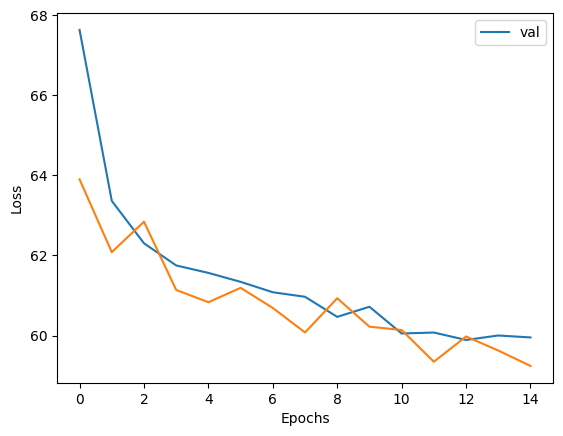

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

TOTAL TEST LOSS  60.07847669647961
TEST TEST TIME 50.19757628440857

 Experiment 4
Epoch n0




1it [00:00,  4.21it/s]

2it [00:00,  4.30it/s]

3it [00:01,  2.44it/s]

4it [00:05,  1.69s/it]

5it [00:06,  1.26s/it]

6it [00:06,  1.05it/s]

7it [00:07,  1.11it/s]

8it [00:07,  1.34it/s]

9it [00:07,  1.71it/s]

10it [00:08,  1.62it/s]

11it [00:09,  1.43it/s]

12it [00:09,  1.71it/s]

13it [00:09,  2.07it/s]

14it [00:10,  1.71it/s]

15it [00:11,  1.54it/s]

16it [00:13,  1.12it/s]

17it [00:13,  1.23it/s]

18it [00:15,  1.02it/s]

19it [00:15,  1.09it/s]

20it [00:18,  1.42s/it]

21it [00:19,  1.18s/it]

22it [00:20,  1.12s/it]

23it [00:21,  1.34s/it]

24it [00:22,  1.05s/it]

25it [00:22,  1.16it/s]

26it [00:23,  1.40it/s]

27it [00:23,  1.72it/s]

28it [00:25,  1.04it/s]

29it [00:25,  1.18it/s]

30it [00:28,  1.31s/it]

31it [00:28,  1.08s/it]

32it [00:29,  1.08s/it]

33it [00:30,  1.05s/it]

34it [00:32,  1.30s/it]

35it [00:33,  1.11s/it]

36it [00:33,  1.19it/s]

37it [00:34,  1.01s/it]

38it [00:35,  1.10it/s]

39it [00:36,  1.11it/s]

40it [00:37,  1.17it/s]

41it [0

TOTAL TRAIN LOSS 67.83558000929628
TRAINING TIME 777.3583548069



  7%|▋         | 1/15 [13:13<3:05:07, 793.37s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 62.96075006928107
EVAL TIME 15.98424482345581
** ** * Saving fine - tuned model ** ** * 


Epoch n1




1it [00:00,  4.50it/s]

2it [00:00,  2.89it/s]

3it [00:01,  3.33it/s]

4it [00:01,  2.85it/s]

5it [00:01,  3.27it/s]

6it [00:02,  1.86it/s]

7it [00:03,  1.53it/s]

8it [00:05,  1.10s/it]

9it [00:07,  1.16s/it]

10it [00:07,  1.02it/s]

11it [00:08,  1.01it/s]

12it [00:09,  1.25it/s]

13it [00:09,  1.59it/s]

14it [00:11,  1.03s/it]

15it [00:11,  1.20it/s]

16it [00:11,  1.53it/s]

17it [00:13,  1.23it/s]

18it [00:14,  1.02it/s]

19it [00:15,  1.06it/s]

20it [00:17,  1.41s/it]

21it [00:20,  1.67s/it]

22it [00:21,  1.51s/it]

23it [00:22,  1.43s/it]

24it [00:23,  1.25s/it]

25it [00:23,  1.01it/s]

26it [00:24,  1.03s/it]

27it [00:25,  1.08s/it]

28it [00:27,  1.18s/it]

29it [00:27,  1.05it/s]

30it [00:28,  1.22it/s]

31it [00:28,  1.41it/s]

32it [00:30,  1.15s/it]

33it [00:31,  1.14it/s]

34it [00:33,  1.22s/it]

35it [00:33,  1.02it/s]

36it [00:35,  1.26s/it]

37it [00:35,  1.01it/s]

38it [00:36,  1.31it/s]

39it [00:36,  1.49it/s]

40it [00:37,  1.62it/s]

41it [0

TOTAL TRAIN LOSS 63.18897054527516
TRAINING TIME 775.9081218242645



 13%|█▎        | 2/15 [26:29<2:52:05, 794.31s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 62.43999741294167
EVAL TIME 20.572585105895996
** ** * Saving fine - tuned model ** ** * 


Epoch n2




1it [00:00,  2.22it/s]

2it [00:01,  1.56it/s]

3it [00:01,  1.77it/s]

4it [00:02,  2.14it/s]

5it [00:02,  1.89it/s]

6it [00:03,  1.66it/s]

7it [00:05,  1.09it/s]

8it [00:07,  1.22s/it]

9it [00:07,  1.02it/s]

10it [00:07,  1.30it/s]

11it [00:08,  1.45it/s]

12it [00:08,  1.68it/s]

13it [00:09,  1.55it/s]

14it [00:10,  1.29it/s]

15it [00:11,  1.51it/s]

16it [00:13,  1.29s/it]

17it [00:14,  1.05s/it]

18it [00:15,  1.07s/it]

19it [00:15,  1.16it/s]

20it [00:15,  1.50it/s]

21it [00:17,  1.20it/s]

22it [00:18,  1.05it/s]

23it [00:18,  1.34it/s]

24it [00:20,  1.04it/s]

25it [00:20,  1.24it/s]

26it [00:21,  1.28it/s]

27it [00:21,  1.49it/s]

28it [00:24,  1.29s/it]

29it [00:26,  1.45s/it]

30it [00:27,  1.34s/it]

31it [00:28,  1.28s/it]

32it [00:30,  1.41s/it]

33it [00:30,  1.08s/it]

34it [00:33,  1.53s/it]

35it [00:33,  1.18s/it]

36it [00:33,  1.13it/s]

37it [00:33,  1.45it/s]

38it [00:34,  1.32it/s]

39it [00:35,  1.46it/s]

40it [00:36,  1.18it/s]

41it [0

TOTAL TRAIN LOSS 62.31438819306353
TRAINING TIME 774.5013766288757



 20%|██        | 3/15 [39:43<2:38:48, 794.05s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 62.53458312063506
EVAL TIME 18.930804014205933


Epoch n3




1it [00:00,  4.86it/s]

2it [00:01,  1.52it/s]

3it [00:03,  1.25it/s]

4it [00:03,  1.27it/s]

5it [00:04,  1.28it/s]

6it [00:05,  1.26it/s]

7it [00:05,  1.59it/s]

8it [00:07,  1.02it/s]

9it [00:07,  1.24it/s]

10it [00:08,  1.50it/s]

11it [00:09,  1.33it/s]

12it [00:10,  1.19it/s]

13it [00:10,  1.22it/s]

14it [00:12,  1.12it/s]

15it [00:12,  1.38it/s]

16it [00:12,  1.72it/s]

17it [00:14,  1.19it/s]

18it [00:14,  1.27it/s]

19it [00:15,  1.28it/s]

20it [00:15,  1.52it/s]

21it [00:17,  1.14it/s]

22it [00:17,  1.35it/s]

23it [00:18,  1.50it/s]

24it [00:18,  1.69it/s]

25it [00:21,  1.28s/it]

26it [00:23,  1.61s/it]

27it [00:24,  1.29s/it]

28it [00:24,  1.00it/s]

29it [00:25,  1.15it/s]

30it [00:25,  1.49it/s]

31it [00:27,  1.03it/s]

32it [00:27,  1.31it/s]

33it [00:29,  1.05s/it]

34it [00:29,  1.19it/s]

35it [00:30,  1.34it/s]

36it [00:30,  1.47it/s]

37it [00:31,  1.62it/s]

38it [00:32,  1.34it/s]

39it [00:34,  1.13s/it]

40it [00:35,  1.24s/it]

41it [0

TOTAL TRAIN LOSS 61.79832368312849
TRAINING TIME 660.0510749816895



 27%|██▋       | 4/15 [50:55<2:18:52, 757.52s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 62.91651518657954
EVAL TIME 12.239461898803711


Epoch n4




1it [00:00,  4.27it/s]

2it [00:00,  4.45it/s]

3it [00:00,  4.55it/s]

4it [00:01,  3.40it/s]

5it [00:01,  2.17it/s]

6it [00:05,  1.29s/it]

7it [00:06,  1.21s/it]

8it [00:07,  1.12s/it]

9it [00:07,  1.14it/s]

10it [00:08,  1.25it/s]

11it [00:08,  1.38it/s]

12it [00:09,  1.25it/s]

13it [00:12,  1.34s/it]

14it [00:12,  1.01s/it]

15it [00:12,  1.28it/s]

16it [00:12,  1.61it/s]

17it [00:13,  2.02it/s]

18it [00:13,  2.40it/s]

19it [00:13,  2.86it/s]

20it [00:13,  3.28it/s]

21it [00:14,  3.38it/s]

22it [00:14,  2.45it/s]

23it [00:17,  1.11s/it]

24it [00:18,  1.06s/it]

25it [00:21,  1.55s/it]

26it [00:21,  1.23s/it]

27it [00:22,  1.19s/it]

28it [00:24,  1.29s/it]

29it [00:25,  1.24s/it]

30it [00:25,  1.07it/s]

31it [00:25,  1.38it/s]

32it [00:28,  1.24s/it]

33it [00:29,  1.20s/it]

34it [00:29,  1.11it/s]

35it [00:29,  1.44it/s]

36it [00:31,  1.01s/it]

37it [00:31,  1.31it/s]

38it [00:32,  1.45it/s]

39it [00:32,  1.85it/s]

40it [00:32,  2.27it/s]

41it [0

TOTAL TRAIN LOSS 61.44366277303728
TRAINING TIME 664.832546710968



 33%|███▎      | 5/15 [1:02:20<2:02:38, 735.86s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 62.21300081773238
EVAL TIME 20.462280988693237
** ** * Saving fine - tuned model ** ** * 


Epoch n5




1it [00:00,  4.40it/s]

2it [00:03,  1.24s/it]

3it [00:04,  1.04it/s]

4it [00:04,  1.15it/s]

5it [00:05,  1.16it/s]

6it [00:06,  1.39it/s]

7it [00:06,  1.34it/s]

8it [00:08,  1.05s/it]

9it [00:08,  1.18it/s]

10it [00:09,  1.19it/s]

11it [00:10,  1.13it/s]

12it [00:11,  1.38it/s]

13it [00:11,  1.57it/s]

14it [00:12,  1.52it/s]

15it [00:15,  1.30s/it]

16it [00:16,  1.33s/it]

17it [00:17,  1.23s/it]

18it [00:18,  1.20s/it]

19it [00:19,  1.23s/it]

20it [00:20,  1.15s/it]

21it [00:22,  1.18s/it]

22it [00:22,  1.12it/s]

23it [00:23,  1.04it/s]

24it [00:23,  1.34it/s]

25it [00:24,  1.31it/s]

26it [00:24,  1.58it/s]

27it [00:25,  1.68it/s]

28it [00:27,  1.12s/it]

29it [00:28,  1.03it/s]

30it [00:30,  1.23s/it]

31it [00:31,  1.23s/it]

32it [00:32,  1.23s/it]

33it [00:32,  1.07it/s]

34it [00:33,  1.39it/s]

35it [00:36,  1.50s/it]

36it [00:36,  1.22s/it]

37it [00:37,  1.02s/it]

38it [00:38,  1.13s/it]

39it [00:40,  1.23s/it]

40it [00:41,  1.18s/it]

41it [0

TOTAL TRAIN LOSS 61.26094292676327
TRAINING TIME 900.7511737346649



 40%|████      | 6/15 [1:17:39<1:58:35, 790.63s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 60.987077963472615
EVAL TIME 17.657444953918457
** ** * Saving fine - tuned model ** ** * 


Epoch n6




1it [00:00,  4.30it/s]

2it [00:00,  2.93it/s]

3it [00:02,  1.23it/s]

4it [00:04,  1.10s/it]

5it [00:05,  1.13s/it]

6it [00:05,  1.16it/s]

7it [00:07,  1.03s/it]

8it [00:09,  1.22s/it]

9it [00:10,  1.30s/it]

10it [00:10,  1.01s/it]

11it [00:11,  1.24it/s]

12it [00:11,  1.38it/s]

13it [00:11,  1.70it/s]

14it [00:16,  1.69s/it]

15it [00:17,  1.47s/it]

16it [00:19,  1.86s/it]

17it [00:20,  1.54s/it]

18it [00:21,  1.22s/it]

19it [00:21,  1.03it/s]

20it [00:21,  1.33it/s]

21it [00:23,  1.05s/it]

22it [00:26,  1.67s/it]

23it [00:27,  1.42s/it]

24it [00:28,  1.17s/it]

25it [00:29,  1.14s/it]

26it [00:29,  1.01s/it]

27it [00:31,  1.22s/it]

28it [00:33,  1.53s/it]

29it [00:35,  1.41s/it]

30it [00:35,  1.21s/it]

31it [00:36,  1.01s/it]

32it [00:36,  1.29it/s]

33it [00:36,  1.53it/s]

34it [00:38,  1.04s/it]

35it [00:39,  1.17it/s]

36it [00:40,  1.16it/s]

37it [00:40,  1.26it/s]

38it [00:41,  1.53it/s]

39it [00:43,  1.08s/it]

40it [00:43,  1.20it/s]

41it [0

TOTAL TRAIN LOSS 61.02923721581326
TRAINING TIME 864.6905901432037



 47%|████▋     | 7/15 [1:32:19<1:48:59, 817.39s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 60.78165468543467
EVAL TIME 15.119745016098022
** ** * Saving fine - tuned model ** ** * 


Epoch n7




1it [00:00,  4.69it/s]

2it [00:02,  1.22it/s]

3it [00:03,  1.06it/s]

4it [00:03,  1.32it/s]

5it [00:04,  1.59it/s]

6it [00:04,  1.97it/s]

7it [00:04,  2.19it/s]

8it [00:05,  2.55it/s]

9it [00:06,  1.72it/s]

10it [00:06,  1.57it/s]

11it [00:07,  1.66it/s]

12it [00:07,  2.06it/s]

13it [00:08,  2.18it/s]

14it [00:08,  2.30it/s]

15it [00:09,  1.94it/s]

16it [00:09,  2.09it/s]

17it [00:09,  2.25it/s]

18it [00:12,  1.13s/it]

19it [00:12,  1.11it/s]

20it [00:13,  1.19it/s]

21it [00:14,  1.15it/s]

22it [00:16,  1.25s/it]

23it [00:16,  1.06it/s]

24it [00:17,  1.17it/s]

25it [00:17,  1.50it/s]

26it [00:18,  1.87it/s]

27it [00:18,  2.12it/s]

28it [00:19,  1.61it/s]

29it [00:19,  1.98it/s]

30it [00:19,  2.37it/s]

31it [00:20,  2.62it/s]

32it [00:20,  2.96it/s]

33it [00:20,  3.09it/s]

34it [00:24,  1.49s/it]

35it [00:25,  1.14s/it]

36it [00:25,  1.01it/s]

37it [00:26,  1.25it/s]

38it [00:27,  1.12it/s]

39it [00:28,  1.10s/it]

40it [00:29,  1.20it/s]

41it [0

TOTAL TRAIN LOSS 60.75776326966853
TRAINING TIME 617.9274842739105



 53%|█████▎    | 8/15 [1:42:48<1:28:47, 761.03s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 62.91905306806468
EVAL TIME 11.60023307800293


Epoch n8




1it [00:00,  4.93it/s]

2it [00:00,  2.65it/s]

3it [00:01,  2.12it/s]

4it [00:02,  2.28it/s]

5it [00:03,  1.41it/s]

6it [00:04,  1.21it/s]

7it [00:05,  1.36it/s]

8it [00:05,  1.29it/s]

9it [00:06,  1.39it/s]

10it [00:06,  1.72it/s]

11it [00:07,  1.57it/s]

12it [00:09,  1.13s/it]

13it [00:10,  1.13it/s]

14it [00:10,  1.21it/s]

15it [00:11,  1.55it/s]

16it [00:12,  1.15it/s]

17it [00:12,  1.30it/s]

18it [00:13,  1.54it/s]

19it [00:14,  1.29it/s]

20it [00:15,  1.33it/s]

21it [00:15,  1.58it/s]

22it [00:15,  1.95it/s]

23it [00:15,  2.27it/s]

24it [00:16,  1.78it/s]

25it [00:16,  2.18it/s]

26it [00:18,  1.51it/s]

27it [00:20,  1.08s/it]

28it [00:22,  1.44s/it]

29it [00:24,  1.65s/it]

30it [00:24,  1.23s/it]

31it [00:25,  1.08s/it]

32it [00:25,  1.22it/s]

33it [00:26,  1.57it/s]

34it [00:27,  1.01s/it]

35it [00:28,  1.28it/s]

36it [00:28,  1.64it/s]

37it [00:28,  2.04it/s]

38it [00:29,  1.92it/s]

39it [00:29,  2.33it/s]

40it [00:31,  1.11it/s]

41it [0

TOTAL TRAIN LOSS 60.47217726572454
TRAINING TIME 674.8081238269806



 60%|██████    | 9/15 [1:54:16<1:13:53, 738.98s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 60.283198693786005
EVAL TIME 12.72004508972168
** ** * Saving fine - tuned model ** ** * 


Epoch n9




1it [00:00,  4.94it/s]

2it [00:02,  1.07it/s]

3it [00:03,  1.35it/s]

4it [00:03,  1.63it/s]

5it [00:04,  1.46it/s]

6it [00:04,  1.67it/s]

7it [00:04,  2.05it/s]

8it [00:07,  1.03s/it]

9it [00:09,  1.42s/it]

10it [00:09,  1.06s/it]

11it [00:10,  1.09it/s]

12it [00:10,  1.41it/s]

13it [00:13,  1.28s/it]

14it [00:13,  1.04it/s]

15it [00:15,  1.21s/it]

16it [00:16,  1.13s/it]

17it [00:17,  1.28s/it]

18it [00:20,  1.72s/it]

19it [00:22,  1.94s/it]

20it [00:23,  1.44s/it]

21it [00:24,  1.40s/it]

22it [00:24,  1.05s/it]

23it [00:25,  1.16it/s]

24it [00:25,  1.47it/s]

25it [00:25,  1.85it/s]

26it [00:26,  2.01it/s]

27it [00:26,  1.66it/s]

28it [00:27,  2.02it/s]

29it [00:28,  1.19it/s]

30it [00:29,  1.43it/s]

31it [00:31,  1.08s/it]

32it [00:32,  1.18s/it]

33it [00:33,  1.18s/it]

34it [00:35,  1.42s/it]

35it [00:37,  1.42s/it]

36it [00:37,  1.08s/it]

37it [00:39,  1.26s/it]

38it [00:39,  1.05it/s]

39it [00:41,  1.22s/it]

40it [00:41,  1.04it/s]

41it [0

TOTAL TRAIN LOSS 60.51715195246488
TRAINING TIME 757.6907958984375



 67%|██████▋   | 10/15 [2:07:07<1:02:23, 748.79s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 60.54546736707591
EVAL TIME 13.973536014556885


Epoch n10




1it [00:00,  4.99it/s]

2it [00:00,  4.88it/s]

3it [00:00,  4.91it/s]

4it [00:00,  4.91it/s]

5it [00:01,  3.24it/s]

6it [00:01,  3.53it/s]

7it [00:03,  1.34it/s]

8it [00:03,  1.45it/s]

9it [00:04,  1.40it/s]

10it [00:05,  1.36it/s]

11it [00:07,  1.12s/it]

12it [00:07,  1.12it/s]

13it [00:08,  1.37it/s]

14it [00:08,  1.68it/s]

15it [00:08,  1.96it/s]

16it [00:09,  1.60it/s]

17it [00:11,  1.04it/s]

18it [00:12,  1.12it/s]

19it [00:12,  1.45it/s]

20it [00:12,  1.84it/s]

21it [00:13,  2.06it/s]

22it [00:13,  1.81it/s]

23it [00:16,  1.22s/it]

24it [00:18,  1.51s/it]

25it [00:19,  1.18s/it]

26it [00:19,  1.02it/s]

27it [00:19,  1.31it/s]

28it [00:20,  1.21it/s]

29it [00:21,  1.56it/s]

30it [00:21,  1.97it/s]

31it [00:22,  1.51it/s]

32it [00:22,  1.91it/s]

33it [00:22,  2.27it/s]

34it [00:23,  1.81it/s]

35it [00:23,  1.93it/s]

36it [00:24,  2.25it/s]

37it [00:24,  2.62it/s]

38it [00:24,  2.95it/s]

39it [00:25,  2.87it/s]

40it [00:25,  2.15it/s]

41it [0

TOTAL TRAIN LOSS 60.41585278538048
TRAINING TIME 617.3539550304413



 73%|███████▎  | 11/15 [2:17:33<47:27, 711.80s/it]  

0it [00:00, ?it/s]

TOTAL VAL LOSS 60.843958276690856
EVAL TIME 8.12931513786316


Epoch n11




1it [00:00,  4.65it/s]

2it [00:00,  3.99it/s]

3it [00:01,  2.12it/s]

4it [00:01,  2.17it/s]

5it [00:02,  2.31it/s]

6it [00:03,  1.50it/s]

7it [00:04,  1.32it/s]

8it [00:04,  1.56it/s]

9it [00:06,  1.04s/it]

10it [00:07,  1.05it/s]

11it [00:07,  1.36it/s]

12it [00:08,  1.31it/s]

13it [00:09,  1.12it/s]

14it [00:10,  1.29it/s]

15it [00:10,  1.65it/s]

16it [00:10,  2.02it/s]

17it [00:11,  2.47it/s]

18it [00:11,  1.85it/s]

19it [00:12,  2.23it/s]

20it [00:12,  2.60it/s]

21it [00:12,  2.97it/s]

22it [00:12,  2.74it/s]

23it [00:13,  2.55it/s]

24it [00:13,  2.97it/s]

25it [00:13,  3.41it/s]

26it [00:15,  1.42it/s]

27it [00:16,  1.43it/s]

28it [00:19,  1.34s/it]

29it [00:20,  1.34s/it]

30it [00:20,  1.01it/s]

31it [00:20,  1.27it/s]

32it [00:21,  1.56it/s]

33it [00:21,  1.94it/s]

34it [00:21,  2.38it/s]

35it [00:21,  2.74it/s]

36it [00:22,  2.69it/s]

37it [00:22,  3.07it/s]

38it [00:22,  3.38it/s]

39it [00:23,  2.45it/s]

40it [00:23,  2.86it/s]

41it [0

TOTAL TRAIN LOSS 60.19439738307102
TRAINING TIME 724.1855990886688



 80%|████████  | 12/15 [2:29:48<35:55, 718.66s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 60.767204303934115
EVAL TIME 10.470162153244019


Epoch n12




1it [00:00,  1.59it/s]

2it [00:02,  1.13s/it]

3it [00:04,  1.18s/it]

4it [00:04,  1.13it/s]

5it [00:05,  1.11it/s]

6it [00:05,  1.27it/s]

7it [00:06,  1.58it/s]

8it [00:06,  1.81it/s]

9it [00:07,  1.49it/s]

10it [00:07,  1.76it/s]

11it [00:08,  1.49it/s]

12it [00:08,  1.86it/s]

13it [00:11,  1.11s/it]

14it [00:12,  1.09s/it]

15it [00:14,  1.33s/it]

16it [00:15,  1.34s/it]

17it [00:16,  1.19s/it]

18it [00:16,  1.04it/s]

19it [00:17,  1.05it/s]

20it [00:18,  1.34it/s]

21it [00:18,  1.61it/s]

22it [00:18,  1.97it/s]

23it [00:19,  2.14it/s]

24it [00:19,  2.11it/s]

25it [00:19,  2.35it/s]

26it [00:20,  2.69it/s]

27it [00:20,  2.05it/s]

28it [00:21,  2.08it/s]

29it [00:22,  1.61it/s]

30it [00:22,  1.57it/s]

31it [00:24,  1.00it/s]

32it [00:25,  1.14it/s]

33it [00:25,  1.35it/s]

34it [00:27,  1.10it/s]

35it [00:29,  1.30s/it]

36it [00:30,  1.23s/it]

37it [00:30,  1.01it/s]

38it [00:31,  1.32it/s]

39it [00:31,  1.38it/s]

40it [00:31,  1.75it/s]

41it [0

TOTAL TRAIN LOSS 60.17043479301651
TRAINING TIME 776.450432062149



 87%|████████▋ | 13/15 [2:43:00<24:41, 740.75s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 60.400167041354706
EVAL TIME 15.832238912582397


Epoch n13




1it [00:00,  4.58it/s]

2it [00:01,  1.56it/s]

3it [00:03,  1.03it/s]

4it [00:05,  1.22s/it]

5it [00:06,  1.11s/it]

6it [00:06,  1.06it/s]

7it [00:07,  1.11it/s]

8it [00:08,  1.24it/s]

9it [00:08,  1.57it/s]

10it [00:08,  1.95it/s]

11it [00:09,  1.56it/s]

12it [00:09,  1.76it/s]

13it [00:10,  2.12it/s]

14it [00:11,  1.46it/s]

15it [00:11,  1.85it/s]

16it [00:14,  1.16s/it]

17it [00:14,  1.11it/s]

18it [00:14,  1.36it/s]

19it [00:15,  1.49it/s]

20it [00:17,  1.10s/it]

21it [00:19,  1.46s/it]

22it [00:20,  1.36s/it]

23it [00:22,  1.33s/it]

24it [00:22,  1.02s/it]

25it [00:23,  1.10s/it]

26it [00:24,  1.01s/it]

27it [00:25,  1.05it/s]

28it [00:25,  1.35it/s]

29it [00:26,  1.56it/s]

30it [00:26,  1.58it/s]

31it [00:27,  1.58it/s]

32it [00:28,  1.26it/s]

33it [00:29,  1.26it/s]

34it [00:29,  1.52it/s]

35it [00:30,  1.39it/s]

36it [00:33,  1.31s/it]

37it [00:33,  1.05s/it]

38it [00:33,  1.24it/s]

39it [00:34,  1.46it/s]

40it [00:34,  1.82it/s]

41it [0

TOTAL TRAIN LOSS 59.93653918446663
TRAINING TIME 783.605926990509



 93%|█████████▎| 14/15 [2:56:17<12:37, 757.77s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 60.211495486172765
EVAL TIME 13.886223793029785
** ** * Saving fine - tuned model ** ** * 


Epoch n14




1it [00:00,  5.05it/s]

2it [00:01,  1.48it/s]

3it [00:02,  1.88it/s]

4it [00:02,  2.09it/s]

5it [00:04,  1.06s/it]

6it [00:05,  1.19it/s]

7it [00:05,  1.24it/s]

8it [00:06,  1.43it/s]

9it [00:08,  1.02it/s]

10it [00:08,  1.09it/s]

11it [00:10,  1.09s/it]

12it [00:10,  1.16it/s]

13it [00:12,  1.01s/it]

14it [00:12,  1.09it/s]

15it [00:13,  1.07it/s]

16it [00:13,  1.37it/s]

17it [00:14,  1.54it/s]

18it [00:14,  1.89it/s]

19it [00:14,  2.15it/s]

20it [00:15,  2.54it/s]

21it [00:16,  1.44it/s]

22it [00:17,  1.51it/s]

23it [00:19,  1.21s/it]

24it [00:20,  1.14s/it]

25it [00:21,  1.03it/s]

26it [00:21,  1.28it/s]

27it [00:21,  1.62it/s]

28it [00:22,  1.38it/s]

29it [00:23,  1.45it/s]

30it [00:23,  1.84it/s]

31it [00:24,  1.46it/s]

32it [00:24,  1.73it/s]

33it [00:26,  1.18it/s]

34it [00:26,  1.41it/s]

35it [00:27,  1.62it/s]

36it [00:27,  1.61it/s]

37it [00:30,  1.26s/it]

38it [00:31,  1.18s/it]

39it [00:32,  1.14s/it]

40it [00:32,  1.10it/s]

41it [0

TOTAL TRAIN LOSS 60.042357028948224
TRAINING TIME 745.1539409160614



100%|██████████| 15/15 [3:09:02<00:00, 756.18s/it]

TOTAL VAL LOSS 61.581463958277844
EVAL TIME 19.74603509902954


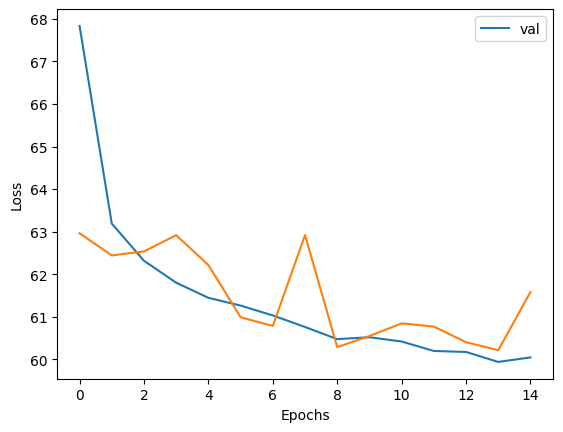

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

TOTAL TEST LOSS  62.313984409580385
TEST TEST TIME 40.08589792251587

 Experiment 5
Epoch n0




1it [00:00,  4.93it/s]

2it [00:00,  3.54it/s]

3it [00:01,  2.97it/s]

4it [00:01,  2.53it/s]

5it [00:02,  1.68it/s]

6it [00:03,  1.64it/s]

7it [00:03,  1.66it/s]

8it [00:04,  2.02it/s]

9it [00:05,  1.58it/s]

10it [00:05,  1.77it/s]

11it [00:06,  1.49it/s]

12it [00:07,  1.29it/s]

13it [00:08,  1.28it/s]

14it [00:08,  1.36it/s]

15it [00:09,  1.61it/s]

16it [00:09,  1.79it/s]

17it [00:11,  1.03it/s]

18it [00:11,  1.34it/s]

19it [00:12,  1.51it/s]

20it [00:13,  1.17it/s]

21it [00:13,  1.48it/s]

22it [00:16,  1.38s/it]

23it [00:17,  1.12s/it]

24it [00:18,  1.01s/it]

25it [00:18,  1.14it/s]

26it [00:19,  1.40it/s]

27it [00:19,  1.70it/s]

28it [00:20,  1.48it/s]

29it [00:21,  1.35it/s]

30it [00:21,  1.60it/s]

31it [00:21,  1.93it/s]

32it [00:22,  2.26it/s]

33it [00:22,  2.37it/s]

34it [00:22,  2.75it/s]

35it [00:23,  1.99it/s]

36it [00:23,  2.35it/s]

37it [00:24,  1.99it/s]

38it [00:25,  1.21it/s]

39it [00:26,  1.28it/s]

40it [00:27,  1.05it/s]

41it [0

TOTAL TRAIN LOSS 67.56712977235476
TRAINING TIME 828.7185962200165



  7%|▋         | 1/15 [14:07<3:17:47, 847.70s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 64.07235940297444
EVAL TIME 18.958197116851807
** ** * Saving fine - tuned model ** ** * 


Epoch n1




1it [00:00,  4.14it/s]

2it [00:01,  1.70it/s]

3it [00:02,  1.68it/s]

4it [00:02,  2.01it/s]

5it [00:04,  1.20it/s]

6it [00:04,  1.44it/s]

7it [00:04,  1.79it/s]

8it [00:05,  2.13it/s]

9it [00:05,  2.31it/s]

10it [00:05,  2.39it/s]

11it [00:06,  1.63it/s]

12it [00:08,  1.25it/s]

13it [00:08,  1.46it/s]

14it [00:09,  1.32it/s]

15it [00:09,  1.48it/s]

16it [00:10,  1.55it/s]

17it [00:10,  1.76it/s]

18it [00:14,  1.41s/it]

19it [00:14,  1.16s/it]

20it [00:16,  1.24s/it]

21it [00:18,  1.43s/it]

22it [00:18,  1.07s/it]

23it [00:18,  1.19it/s]

24it [00:18,  1.45it/s]

25it [00:21,  1.27s/it]

26it [00:22,  1.20s/it]

27it [00:25,  1.78s/it]

28it [00:26,  1.55s/it]

29it [00:27,  1.16s/it]

30it [00:27,  1.03it/s]

31it [00:28,  1.10s/it]

32it [00:29,  1.09it/s]

33it [00:29,  1.42it/s]

34it [00:29,  1.76it/s]

35it [00:30,  2.13it/s]

36it [00:30,  2.05it/s]

37it [00:30,  2.45it/s]

38it [00:31,  2.79it/s]

39it [00:31,  2.48it/s]

40it [00:32,  1.91it/s]

41it [0

TOTAL TRAIN LOSS 63.25302065161319
TRAINING TIME 698.266508102417



 13%|█▎        | 2/15 [26:00<2:54:55, 807.36s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 62.36833760232636
EVAL TIME 14.947298765182495
** ** * Saving fine - tuned model ** ** * 


Epoch n2




1it [00:00,  2.70it/s]

2it [00:00,  2.97it/s]

3it [00:00,  3.14it/s]

4it [00:01,  3.45it/s]

5it [00:01,  3.79it/s]

6it [00:01,  2.97it/s]

7it [00:02,  2.42it/s]

8it [00:03,  1.75it/s]

9it [00:06,  1.22s/it]

10it [00:06,  1.04s/it]

11it [00:07,  1.03s/it]

12it [00:08,  1.20it/s]

13it [00:08,  1.49it/s]

14it [00:09,  1.51it/s]

15it [00:09,  1.53it/s]

16it [00:10,  1.27it/s]

17it [00:11,  1.41it/s]

18it [00:11,  1.77it/s]

19it [00:11,  1.91it/s]

20it [00:14,  1.04s/it]

21it [00:14,  1.20it/s]

22it [00:14,  1.43it/s]

23it [00:15,  1.48it/s]

24it [00:16,  1.24it/s]

25it [00:16,  1.59it/s]

26it [00:17,  1.52it/s]

27it [00:20,  1.26s/it]

28it [00:20,  1.07s/it]

29it [00:22,  1.31s/it]

30it [00:23,  1.05s/it]

31it [00:23,  1.07it/s]

32it [00:24,  1.31it/s]

33it [00:24,  1.41it/s]

34it [00:25,  1.48it/s]

35it [00:26,  1.31it/s]

36it [00:27,  1.28it/s]

37it [00:27,  1.29it/s]

38it [00:28,  1.22it/s]

39it [00:29,  1.54it/s]

40it [00:30,  1.35it/s]

41it [0

TOTAL TRAIN LOSS 62.771691163560945
TRAINING TIME 682.2324311733246



 20%|██        | 3/15 [37:41<2:35:04, 775.40s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 62.25059254000885
EVAL TIME 18.560424089431763
** ** * Saving fine - tuned model ** ** * 


Epoch n3




1it [00:00,  4.92it/s]

2it [00:00,  2.97it/s]

3it [00:01,  1.84it/s]

4it [00:04,  1.11s/it]

5it [00:04,  1.20it/s]

6it [00:04,  1.48it/s]

7it [00:05,  1.72it/s]

8it [00:05,  1.58it/s]

9it [00:06,  1.35it/s]

10it [00:07,  1.62it/s]

11it [00:07,  1.90it/s]

12it [00:07,  2.30it/s]

13it [00:07,  2.70it/s]

14it [00:10,  1.08it/s]

15it [00:10,  1.38it/s]

16it [00:11,  1.40it/s]

17it [00:11,  1.64it/s]

18it [00:14,  1.38s/it]

19it [00:16,  1.61s/it]

20it [00:17,  1.22s/it]

21it [00:17,  1.08it/s]

22it [00:17,  1.35it/s]

23it [00:18,  1.38it/s]

24it [00:19,  1.29it/s]

25it [00:21,  1.28s/it]

26it [00:22,  1.13s/it]

27it [00:22,  1.09it/s]

28it [00:23,  1.24it/s]

29it [00:24,  1.14it/s]

30it [00:24,  1.37it/s]

31it [00:26,  1.11it/s]

32it [00:27,  1.12s/it]

33it [00:28,  1.18it/s]

34it [00:28,  1.45it/s]

35it [00:28,  1.80it/s]

36it [00:28,  2.20it/s]

37it [00:29,  2.38it/s]

38it [00:29,  2.77it/s]

39it [00:29,  3.07it/s]

40it [00:30,  3.05it/s]

41it [0

TOTAL TRAIN LOSS 62.100084068281056
TRAINING TIME 619.8607540130615



 27%|██▋       | 4/15 [48:18<2:14:33, 733.93s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 62.26216672646879
EVAL TIME 17.329856157302856


Epoch n4




1it [00:00,  4.19it/s]

2it [00:00,  2.65it/s]

3it [00:01,  2.00it/s]

4it [00:01,  2.43it/s]

5it [00:02,  2.14it/s]

6it [00:03,  1.92it/s]

7it [00:04,  1.37it/s]

8it [00:05,  1.37it/s]

9it [00:07,  1.15s/it]

10it [00:09,  1.61s/it]

11it [00:10,  1.36s/it]

12it [00:12,  1.36s/it]

13it [00:12,  1.02s/it]

14it [00:13,  1.02s/it]

15it [00:13,  1.25it/s]

16it [00:14,  1.06it/s]

17it [00:16,  1.08s/it]

18it [00:17,  1.00s/it]

19it [00:17,  1.15it/s]

20it [00:18,  1.13it/s]

21it [00:19,  1.31it/s]

22it [00:19,  1.30it/s]

23it [00:20,  1.44it/s]

24it [00:21,  1.30it/s]

25it [00:21,  1.53it/s]

26it [00:22,  1.77it/s]

27it [00:22,  2.12it/s]

28it [00:22,  2.23it/s]

29it [00:23,  1.96it/s]

30it [00:25,  1.11it/s]

31it [00:25,  1.24it/s]

32it [00:26,  1.45it/s]

33it [00:26,  1.81it/s]

34it [00:27,  1.65it/s]

35it [00:28,  1.28it/s]

36it [00:31,  1.39s/it]

37it [00:31,  1.17s/it]

38it [00:32,  1.10it/s]

39it [00:33,  1.14s/it]

40it [00:34,  1.03it/s]

41it [0

TOTAL TRAIN LOSS 61.77885163005859
TRAINING TIME 698.9341008663177



 33%|███▎      | 5/15 [1:00:11<2:01:15, 727.53s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 62.88506734250772
EVAL TIME 13.637656211853027


Epoch n5




1it [00:00,  4.84it/s]

2it [00:00,  3.92it/s]

3it [00:00,  3.95it/s]

4it [00:01,  3.91it/s]

5it [00:01,  2.31it/s]

6it [00:02,  1.66it/s]

7it [00:05,  1.08s/it]

8it [00:07,  1.45s/it]

9it [00:07,  1.08s/it]

10it [00:08,  1.14it/s]

11it [00:08,  1.39it/s]

12it [00:08,  1.73it/s]

13it [00:09,  1.93it/s]

14it [00:09,  2.28it/s]

15it [00:09,  2.03it/s]

16it [00:10,  2.39it/s]

17it [00:12,  1.15it/s]

18it [00:12,  1.46it/s]

19it [00:12,  1.83it/s]

20it [00:12,  2.23it/s]

21it [00:12,  2.60it/s]

22it [00:13,  2.97it/s]

23it [00:13,  3.32it/s]

24it [00:13,  3.19it/s]

25it [00:16,  1.07s/it]

26it [00:17,  1.02it/s]

27it [00:17,  1.18it/s]

28it [00:18,  1.50it/s]

29it [00:20,  1.06s/it]

30it [00:21,  1.28s/it]

31it [00:22,  1.03s/it]

32it [00:22,  1.12it/s]

33it [00:25,  1.49s/it]

34it [00:26,  1.23s/it]

35it [00:28,  1.52s/it]

36it [00:29,  1.21s/it]

37it [00:29,  1.03it/s]

38it [00:29,  1.34it/s]

39it [00:30,  1.67it/s]

40it [00:30,  2.06it/s]

41it [0

TOTAL TRAIN LOSS 61.34298633476076
TRAINING TIME 660.7585217952728



 40%|████      | 6/15 [1:11:30<1:46:55, 712.83s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 61.73818718303334
EVAL TIME 17.76321792602539
** ** * Saving fine - tuned model ** ** * 


Epoch n6




1it [00:00,  2.44it/s]

2it [00:04,  1.52s/it]

3it [00:05,  1.30s/it]

4it [00:06,  1.17s/it]

5it [00:06,  1.03it/s]

6it [00:07,  1.28it/s]

7it [00:07,  1.54it/s]

8it [00:07,  1.93it/s]

9it [00:07,  2.34it/s]

10it [00:08,  2.40it/s]

11it [00:08,  2.78it/s]

12it [00:08,  2.97it/s]

13it [00:08,  3.34it/s]

14it [00:09,  3.55it/s]

15it [00:09,  2.67it/s]

16it [00:10,  2.74it/s]

17it [00:10,  3.13it/s]

18it [00:10,  3.44it/s]

19it [00:10,  3.05it/s]

20it [00:11,  3.35it/s]

21it [00:11,  2.57it/s]

22it [00:12,  2.40it/s]

23it [00:13,  1.69it/s]

24it [00:13,  1.67it/s]

25it [00:15,  1.21it/s]

26it [00:15,  1.36it/s]

27it [00:16,  1.47it/s]

28it [00:16,  1.73it/s]

29it [00:18,  1.02it/s]

30it [00:19,  1.04it/s]

31it [00:20,  1.00it/s]

32it [00:21,  1.19it/s]

33it [00:21,  1.55it/s]

34it [00:21,  1.56it/s]

35it [00:23,  1.09it/s]

36it [00:23,  1.34it/s]

37it [00:24,  1.37it/s]

38it [00:24,  1.62it/s]

39it [00:25,  1.94it/s]

40it [00:25,  1.89it/s]

41it [0

TOTAL TRAIN LOSS 61.26881955299075
TRAINING TIME 720.3944730758667



 47%|████▋     | 7/15 [1:23:44<1:35:55, 719.38s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 61.46184767135466
EVAL TIME 14.267447710037231
** ** * Saving fine - tuned model ** ** * 


Epoch n7




1it [00:00,  4.63it/s]

2it [00:00,  3.63it/s]

3it [00:00,  3.81it/s]

4it [00:01,  3.97it/s]

5it [00:01,  4.12it/s]

6it [00:01,  4.31it/s]

7it [00:01,  4.24it/s]

8it [00:02,  3.13it/s]

9it [00:04,  1.02it/s]

10it [00:05,  1.14it/s]

11it [00:05,  1.49it/s]

12it [00:06,  1.17it/s]

13it [00:07,  1.32it/s]

14it [00:07,  1.57it/s]

15it [00:08,  1.69it/s]

16it [00:08,  1.89it/s]

17it [00:10,  1.10it/s]

18it [00:10,  1.34it/s]

19it [00:11,  1.62it/s]

20it [00:12,  1.32it/s]

21it [00:12,  1.62it/s]

22it [00:12,  1.98it/s]

23it [00:12,  2.36it/s]

24it [00:13,  2.73it/s]

25it [00:14,  1.61it/s]

26it [00:17,  1.22s/it]

27it [00:18,  1.22s/it]

28it [00:20,  1.62s/it]

29it [00:21,  1.29s/it]

30it [00:21,  1.02it/s]

31it [00:21,  1.32it/s]

32it [00:22,  1.65it/s]

33it [00:22,  2.06it/s]

34it [00:22,  2.47it/s]

35it [00:22,  2.86it/s]

36it [00:23,  1.84it/s]

37it [00:23,  2.25it/s]

38it [00:24,  2.69it/s]

39it [00:25,  1.74it/s]

40it [00:27,  1.01it/s]

41it [0

TOTAL TRAIN LOSS 60.905084053765336
TRAINING TIME 733.4045219421387



 53%|█████▎    | 8/15 [1:36:32<1:25:37, 733.88s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 61.487506471499046
EVAL TIME 34.310063123703


Epoch n8




1it [00:00,  4.65it/s]

2it [00:00,  4.25it/s]

3it [00:00,  4.01it/s]

4it [00:01,  2.96it/s]

5it [00:02,  2.11it/s]

6it [00:02,  2.48it/s]

7it [00:02,  2.76it/s]

8it [00:03,  1.59it/s]

9it [00:04,  1.55it/s]

10it [00:05,  1.65it/s]

11it [00:07,  1.14s/it]

12it [00:07,  1.14it/s]

13it [00:10,  1.49s/it]

14it [00:12,  1.45s/it]

15it [00:12,  1.19s/it]

16it [00:14,  1.30s/it]

17it [00:14,  1.06s/it]

18it [00:15,  1.17it/s]

19it [00:16,  1.06s/it]

20it [00:17,  1.07it/s]

21it [00:17,  1.20it/s]

22it [00:18,  1.33it/s]

23it [00:21,  1.37s/it]

24it [00:22,  1.44s/it]

25it [00:23,  1.23s/it]

26it [00:24,  1.01s/it]

27it [00:24,  1.09it/s]

28it [00:24,  1.39it/s]

29it [00:26,  1.11it/s]

30it [00:27,  1.11s/it]

31it [00:28,  1.13it/s]

32it [00:30,  1.44s/it]

33it [00:32,  1.52s/it]

34it [00:34,  1.47s/it]

35it [00:36,  1.80s/it]

36it [00:37,  1.67s/it]

37it [00:40,  1.87s/it]

38it [00:40,  1.50s/it]

39it [00:41,  1.14s/it]

40it [00:41,  1.13it/s]

41it [0

TOTAL TRAIN LOSS 60.67142258144046
TRAINING TIME 898.2021682262421



 60%|██████    | 9/15 [1:51:53<1:19:00, 790.01s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 61.43571896986528
EVAL TIME 22.763002157211304
** ** * Saving fine - tuned model ** ** * 


Epoch n9




1it [00:00,  3.49it/s]

2it [00:00,  2.70it/s]

3it [00:01,  3.05it/s]

4it [00:02,  1.90it/s]

5it [00:02,  2.32it/s]

6it [00:02,  2.39it/s]

7it [00:03,  2.12it/s]

8it [00:03,  2.39it/s]

9it [00:04,  1.72it/s]

10it [00:05,  1.49it/s]

11it [00:06,  1.32it/s]

12it [00:06,  1.51it/s]

13it [00:07,  1.45it/s]

14it [00:07,  1.78it/s]

15it [00:08,  1.50it/s]

16it [00:09,  1.79it/s]

17it [00:09,  1.62it/s]

18it [00:10,  1.47it/s]

19it [00:10,  1.74it/s]

20it [00:11,  1.67it/s]

21it [00:11,  1.87it/s]

22it [00:12,  1.90it/s]

23it [00:12,  2.06it/s]

24it [00:13,  2.42it/s]

25it [00:14,  1.73it/s]

26it [00:15,  1.16it/s]

27it [00:18,  1.54s/it]

28it [00:19,  1.33s/it]

29it [00:22,  1.81s/it]

30it [00:24,  1.79s/it]

31it [00:24,  1.39s/it]

32it [00:26,  1.48s/it]

33it [00:28,  1.64s/it]

34it [00:28,  1.27s/it]

35it [00:30,  1.51s/it]

36it [00:33,  1.83s/it]

37it [00:34,  1.55s/it]

38it [00:35,  1.51s/it]

39it [00:36,  1.18s/it]

40it [00:37,  1.34s/it]

41it [0

TOTAL TRAIN LOSS 60.481986529694815
TRAINING TIME 775.2130401134491



 67%|██████▋   | 10/15 [2:05:07<1:05:56, 791.25s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 61.74057628169204
EVAL TIME 18.927997827529907


Epoch n10




1it [00:00,  4.58it/s]

2it [00:00,  2.67it/s]

3it [00:01,  2.14it/s]

4it [00:02,  1.84it/s]

5it [00:02,  1.87it/s]

6it [00:03,  1.84it/s]

7it [00:03,  1.92it/s]

8it [00:04,  1.90it/s]

9it [00:05,  1.79it/s]

10it [00:05,  2.11it/s]

11it [00:05,  2.49it/s]

12it [00:06,  2.28it/s]

13it [00:07,  1.15it/s]

14it [00:08,  1.47it/s]

15it [00:09,  1.36it/s]

16it [00:09,  1.70it/s]

17it [00:09,  1.93it/s]

18it [00:12,  1.08s/it]

19it [00:12,  1.09it/s]

20it [00:12,  1.41it/s]

21it [00:13,  1.66it/s]

22it [00:13,  2.06it/s]

23it [00:15,  1.04s/it]

24it [00:16,  1.19it/s]

25it [00:16,  1.46it/s]

26it [00:16,  1.79it/s]

27it [00:17,  1.35it/s]

28it [00:18,  1.71it/s]

29it [00:20,  1.28s/it]

30it [00:22,  1.35s/it]

31it [00:22,  1.07s/it]

32it [00:23,  1.11it/s]

33it [00:23,  1.43it/s]

34it [00:24,  1.54it/s]

35it [00:24,  1.90it/s]

36it [00:24,  2.26it/s]

37it [00:25,  2.35it/s]

38it [00:26,  1.18it/s]

39it [00:27,  1.42it/s]

40it [00:28,  1.23it/s]

41it [0

TOTAL TRAIN LOSS 60.47780476502087
TRAINING TIME 717.8369781970978



 73%|███████▎  | 11/15 [2:17:20<51:35, 773.88s/it]  

0it [00:00, ?it/s]

TOTAL VAL LOSS 59.96763773638793
EVAL TIME 15.481253147125244
** ** * Saving fine - tuned model ** ** * 


Epoch n11




1it [00:00,  2.88it/s]

2it [00:00,  3.18it/s]

3it [00:00,  3.18it/s]

4it [00:03,  1.02s/it]

5it [00:03,  1.29it/s]

6it [00:03,  1.66it/s]

7it [00:04,  1.87it/s]

8it [00:04,  2.21it/s]

9it [00:04,  2.57it/s]

10it [00:07,  1.01s/it]

11it [00:07,  1.20it/s]

12it [00:07,  1.54it/s]

13it [00:08,  1.93it/s]

14it [00:09,  1.18it/s]

15it [00:10,  1.17it/s]

16it [00:11,  1.37it/s]

17it [00:12,  1.01s/it]

18it [00:13,  1.02s/it]

19it [00:14,  1.09it/s]

20it [00:14,  1.41it/s]

21it [00:17,  1.31s/it]

22it [00:17,  1.09s/it]

23it [00:18,  1.20it/s]

24it [00:18,  1.51it/s]

25it [00:19,  1.42it/s]

26it [00:19,  1.70it/s]

27it [00:20,  1.66it/s]

28it [00:21,  1.11it/s]

29it [00:22,  1.07it/s]

30it [00:23,  1.31it/s]

31it [00:24,  1.21it/s]

32it [00:24,  1.38it/s]

33it [00:26,  1.20s/it]

34it [00:27,  1.12s/it]

35it [00:29,  1.27s/it]

36it [00:31,  1.47s/it]

37it [00:32,  1.30s/it]

38it [00:32,  1.00s/it]

39it [00:33,  1.08it/s]

40it [00:33,  1.32it/s]

41it [0

TOTAL TRAIN LOSS 60.482545957424904
TRAINING TIME 748.9913237094879



 80%|████████  | 12/15 [2:30:13<38:40, 773.38s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 60.701837395176746
EVAL TIME 23.21680474281311


Epoch n12




1it [00:00,  4.08it/s]

2it [00:00,  3.39it/s]

3it [00:02,  1.49it/s]

4it [00:02,  1.89it/s]

5it [00:03,  1.53it/s]

6it [00:03,  1.54it/s]

7it [00:04,  1.76it/s]

8it [00:04,  1.91it/s]

9it [00:05,  1.43it/s]

10it [00:06,  1.78it/s]

11it [00:06,  1.96it/s]

12it [00:08,  1.09it/s]

13it [00:09,  1.20it/s]

14it [00:11,  1.37s/it]

15it [00:12,  1.32s/it]

16it [00:13,  1.04s/it]

17it [00:15,  1.53s/it]

18it [00:16,  1.23s/it]

19it [00:16,  1.02it/s]

20it [00:17,  1.32it/s]

21it [00:17,  1.33it/s]

22it [00:18,  1.54it/s]

23it [00:18,  1.94it/s]

24it [00:18,  2.32it/s]

25it [00:19,  2.12it/s]

26it [00:19,  2.44it/s]

27it [00:20,  1.44it/s]

28it [00:21,  1.36it/s]

29it [00:22,  1.47it/s]

30it [00:22,  1.49it/s]

31it [00:23,  1.44it/s]

32it [00:26,  1.20s/it]

33it [00:27,  1.16s/it]

34it [00:28,  1.16s/it]

35it [00:30,  1.61s/it]

36it [00:31,  1.25s/it]

37it [00:31,  1.06it/s]

38it [00:31,  1.37it/s]

39it [00:32,  1.70it/s]

40it [00:32,  2.08it/s]

41it [0

TOTAL TRAIN LOSS 60.09212012739171
TRAINING TIME 753.427387714386



 87%|████████▋ | 13/15 [2:43:02<25:44, 772.05s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 60.07099440603545
EVAL TIME 15.533438205718994


Epoch n13




1it [00:00,  2.13it/s]

2it [00:01,  1.94it/s]

3it [00:01,  2.36it/s]

4it [00:02,  1.83it/s]

5it [00:02,  1.79it/s]

6it [00:03,  1.86it/s]

7it [00:03,  2.05it/s]

8it [00:03,  2.44it/s]

9it [00:04,  2.01it/s]

10it [00:04,  2.34it/s]

11it [00:05,  1.52it/s]

12it [00:06,  1.88it/s]

13it [00:06,  1.94it/s]

14it [00:07,  1.80it/s]

15it [00:07,  2.16it/s]

16it [00:07,  2.55it/s]

17it [00:08,  2.53it/s]

18it [00:08,  2.89it/s]

19it [00:08,  3.23it/s]

20it [00:08,  3.57it/s]

21it [00:11,  1.15it/s]

22it [00:13,  1.39s/it]

23it [00:14,  1.13s/it]

24it [00:15,  1.29s/it]

25it [00:16,  1.03it/s]

26it [00:16,  1.08it/s]

27it [00:17,  1.29it/s]

28it [00:17,  1.41it/s]

29it [00:19,  1.09s/it]

30it [00:20,  1.03s/it]

31it [00:21,  1.20it/s]

32it [00:21,  1.33it/s]

33it [00:23,  1.12s/it]

34it [00:23,  1.19it/s]

35it [00:24,  1.53it/s]

36it [00:24,  1.80it/s]

37it [00:24,  1.80it/s]

38it [00:25,  2.19it/s]

39it [00:25,  2.49it/s]

40it [00:27,  1.03it/s]

41it [0

TOTAL TRAIN LOSS 59.97255323157305
TRAINING TIME 662.2208461761475



 93%|█████████▎| 14/15 [2:54:20<12:24, 744.00s/it]

0it [00:00, ?it/s]

TOTAL VAL LOSS 61.007328852258546
EVAL TIME 16.325427055358887


Epoch n14




1it [00:00,  4.95it/s]

2it [00:00,  4.67it/s]

3it [00:00,  4.21it/s]

4it [00:00,  4.25it/s]

5it [00:01,  3.41it/s]

6it [00:01,  3.65it/s]

7it [00:03,  1.11it/s]

8it [00:04,  1.37it/s]

9it [00:05,  1.23it/s]

10it [00:05,  1.57it/s]

11it [00:05,  1.96it/s]

12it [00:07,  1.20it/s]

13it [00:09,  1.22s/it]

14it [00:10,  1.03s/it]

15it [00:10,  1.11it/s]

16it [00:11,  1.31it/s]

17it [00:12,  1.02s/it]

18it [00:13,  1.14it/s]

19it [00:13,  1.40it/s]

20it [00:14,  1.48it/s]

21it [00:14,  1.83it/s]

22it [00:15,  1.63it/s]

23it [00:17,  1.27s/it]

24it [00:20,  1.67s/it]

25it [00:21,  1.49s/it]

26it [00:21,  1.11s/it]

27it [00:22,  1.11it/s]

28it [00:22,  1.41it/s]

29it [00:24,  1.01s/it]

30it [00:24,  1.31it/s]

31it [00:24,  1.63it/s]

32it [00:24,  2.00it/s]

33it [00:25,  2.29it/s]

34it [00:26,  1.85it/s]

35it [00:26,  2.05it/s]

36it [00:28,  1.08it/s]

37it [00:28,  1.31it/s]

38it [00:31,  1.27s/it]

39it [00:32,  1.16s/it]

40it [00:32,  1.01s/it]

41it [0

TOTAL TRAIN LOSS 60.409819207672086
TRAINING TIME 793.3183889389038



100%|██████████| 15/15 [3:07:52<00:00, 751.51s/it]

TOTAL VAL LOSS 60.7882315221459
EVAL TIME 18.689276933670044


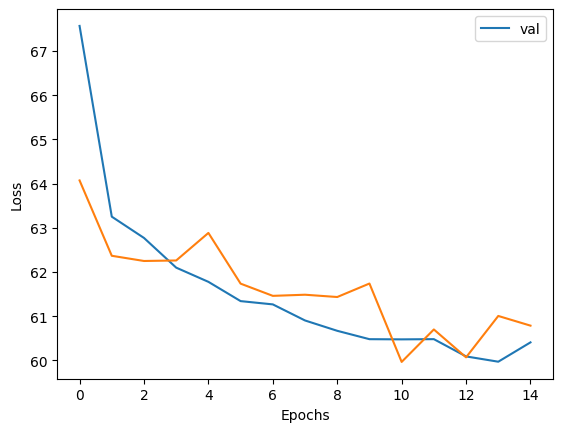

100%|██████████| 5/5 [11:47:37<00:00, 8491.56s/it] 

TOTAL TEST LOSS  60.3950479553967
TEST TEST TIME 52.578633308410645


AttributeError: 'DataFrame' object has no attribute 'F'

In [15]:
df = experiment(num_experiments=5)

In [ ]:
df

In [ ]:
# Group by Model and Metric and calculate average and standard deviation
result_df = df.groupby(['Model', 'Metric']).agg({'Score': ['mean', 'std']}).reset_index()

# Rename columns for clarity
result_df.columns = ['Model', 'Metric', 'Average Score', 'Standard Deviation']

result_df['Average Score'] = result_df['Average Score'].round(2)
result_df['Standard Deviation'] = result_df['Standard Deviation'].round(2)

# Print the result
print(result_df)

In [ ]:
# saving results
result_df.to_csv(path_results + 'dataframes/' + 'GT_behrt_results_pretraining_2.csv')